In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')


In [3]:
data_dfs = []
for holdouts in range(8):
    data_df = pd.read_csv(f'/ihme/covid-19/deaths/dev/2020_05_18_h{holdouts}/model_data.csv')
    data_df['date'] = pd.to_datetime(data_df['Date'])
    data_df = data_df.sort_values(['location_id', 'date'])
    data_df['Cumulative observed'] = data_df['Death rate'] * data_df['population']
    first_day = data_df['date'] == data_df.groupby('location_id')['date'].transform(min)
    data_df['Daily observed'] = np.nan
    data_df['Daily observed'][1:] = np.diff(data_df['Cumulative observed'])
    data_df.loc[first_day, 'Daily observed'] = data_df['Cumulative observed']
    data_dfs.append(data_df[['location_id', 'date', 'Cumulative observed', 'Daily observed']])
del data_df

est_dfs = []
for holdouts in range(8):
    est_df = pd.read_csv(f'/ihme/covid-19/deaths/dev/2020_05_18_h{holdouts}/model_results.csv')
    est_df['date'] = pd.to_datetime(est_df['date'])
    est_df = est_df.sort_values(['location_id', 'date'])
    est_df['Cumulative mean'] = est_df[[f'draw_{d}' for d in range(1000)]].mean(axis=1)
    est_df['Cumulative lower'] = np.percentile(est_df[[f'draw_{d}' for d in range(1000)]], 2.5, axis=1)
    est_df['Cumulative upper'] = np.percentile(est_df[[f'draw_{d}' for d in range(1000)]], 97.5, axis=1)
    est_df['Daily mean'] = np.nan
    est_df['Daily mean'][1:] = np.diff(est_df[[f'draw_{d}' for d in range(1000)]], axis=0).mean(axis=1)
    est_df['Daily lower'] = np.nan
    est_df['Daily lower'][1:] = np.percentile(np.diff(est_df[[f'draw_{d}' for d in range(1000)]], axis=0), 2.5, axis=1)
    est_df['Daily upper'] = np.nan
    est_df['Daily upper'][1:] = np.percentile(np.diff(est_df[[f'draw_{d}' for d in range(1000)]], axis=0), 97.5, axis=1)
    first_day = est_df['date'] == est_df.groupby('location_id')['date'].transform(min)
    est_df.loc[first_day, 'Daily mean'] = est_df['Cumulative mean']
    est_df.loc[first_day, 'Daily lower'] = est_df['Cumulative lower']
    est_df.loc[first_day, 'Daily upper'] = est_df['Cumulative upper']
    est_dfs.append(est_df[['location_id', 'date', 
                           'Cumulative mean', 'Cumulative lower', 'Cumulative upper', 
                           'Daily mean', 'Daily lower', 'Daily upper']])
del est_df


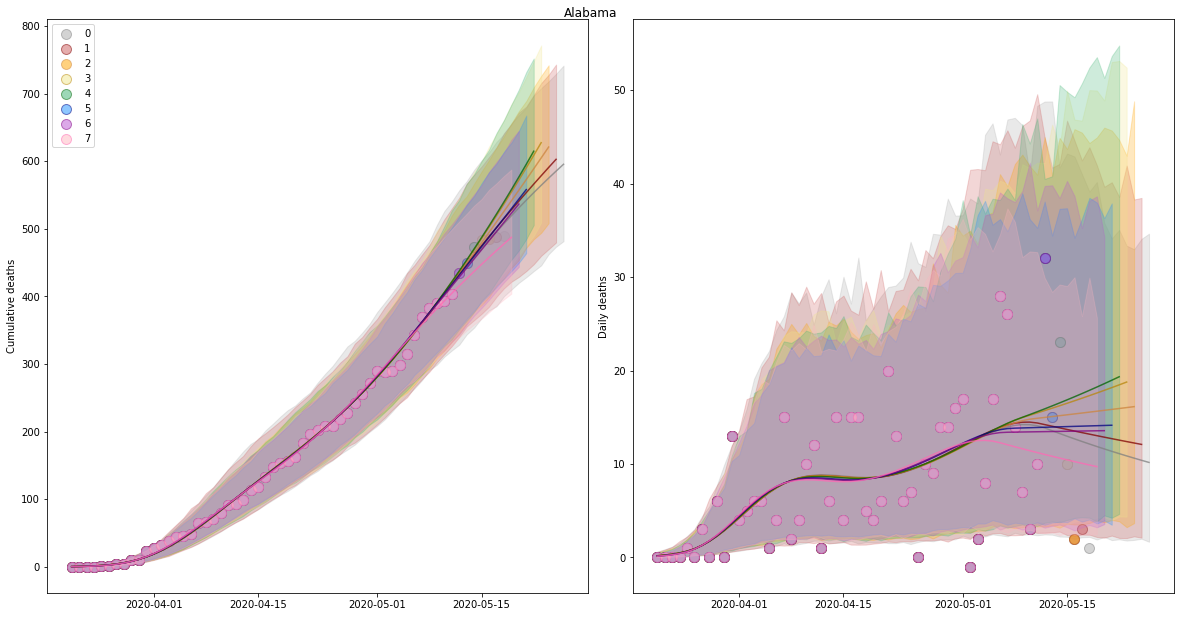

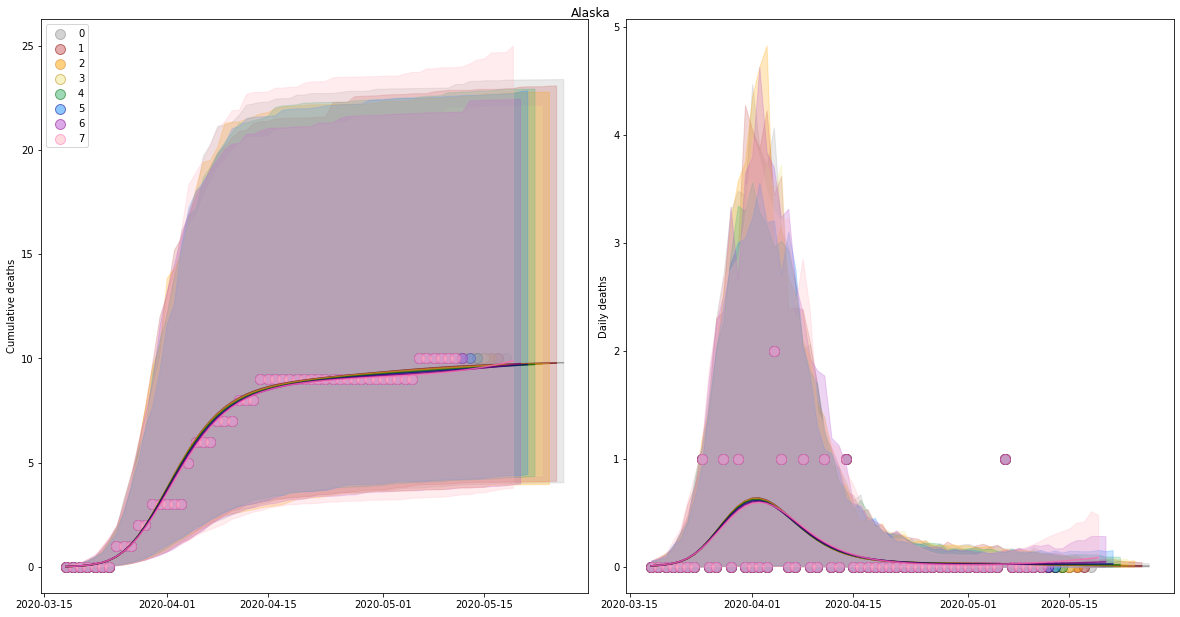

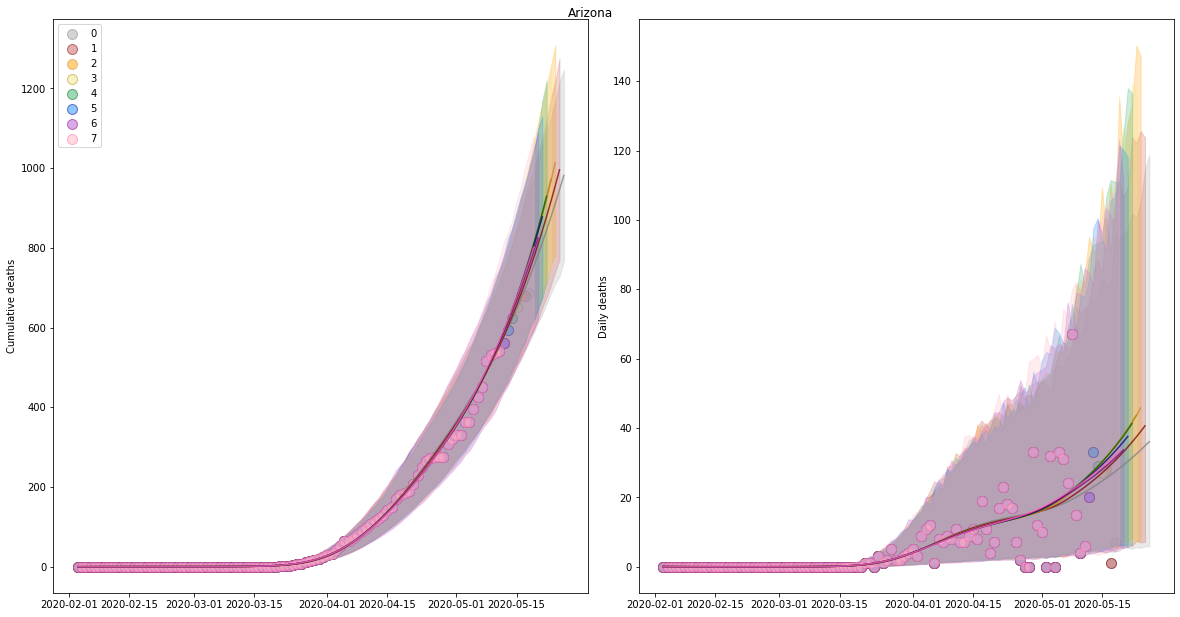

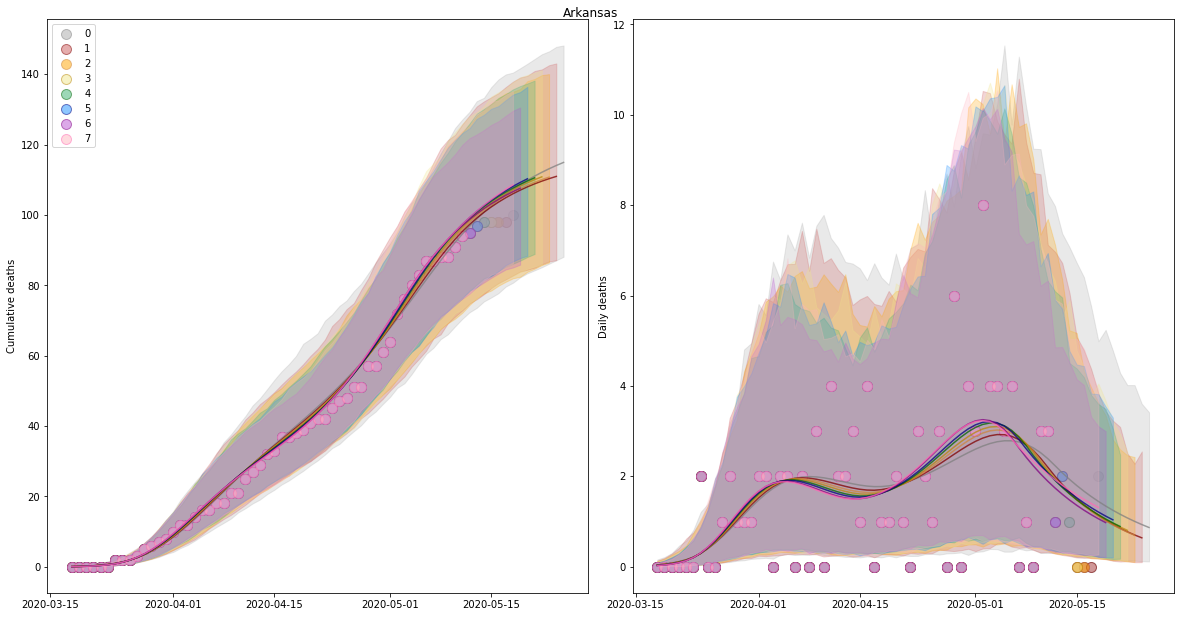

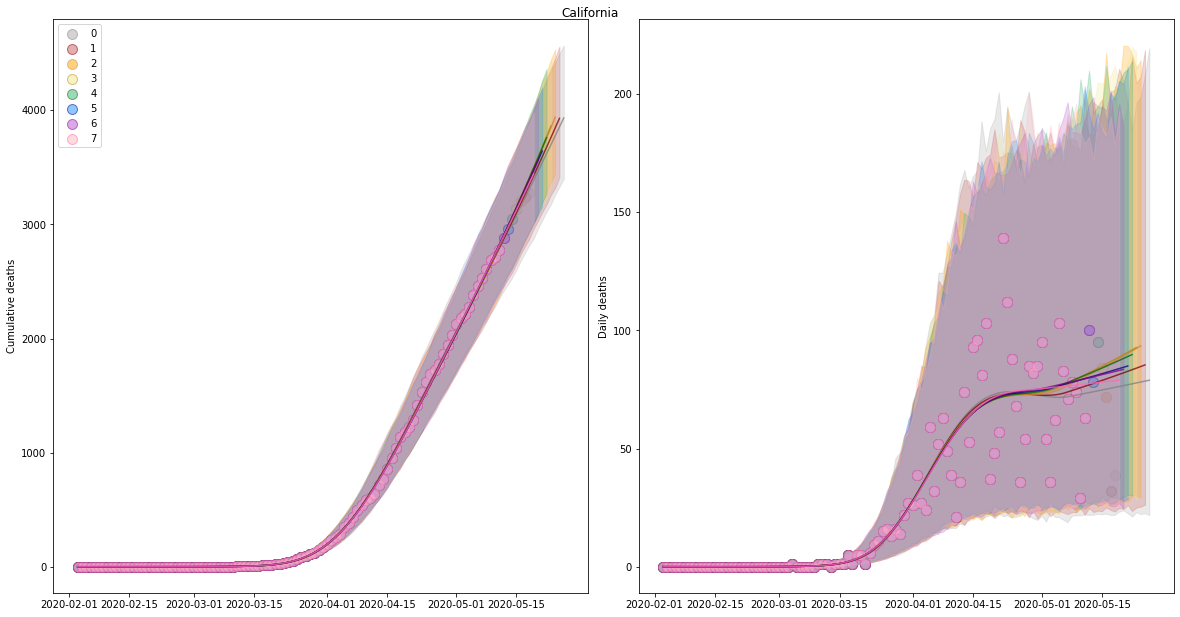

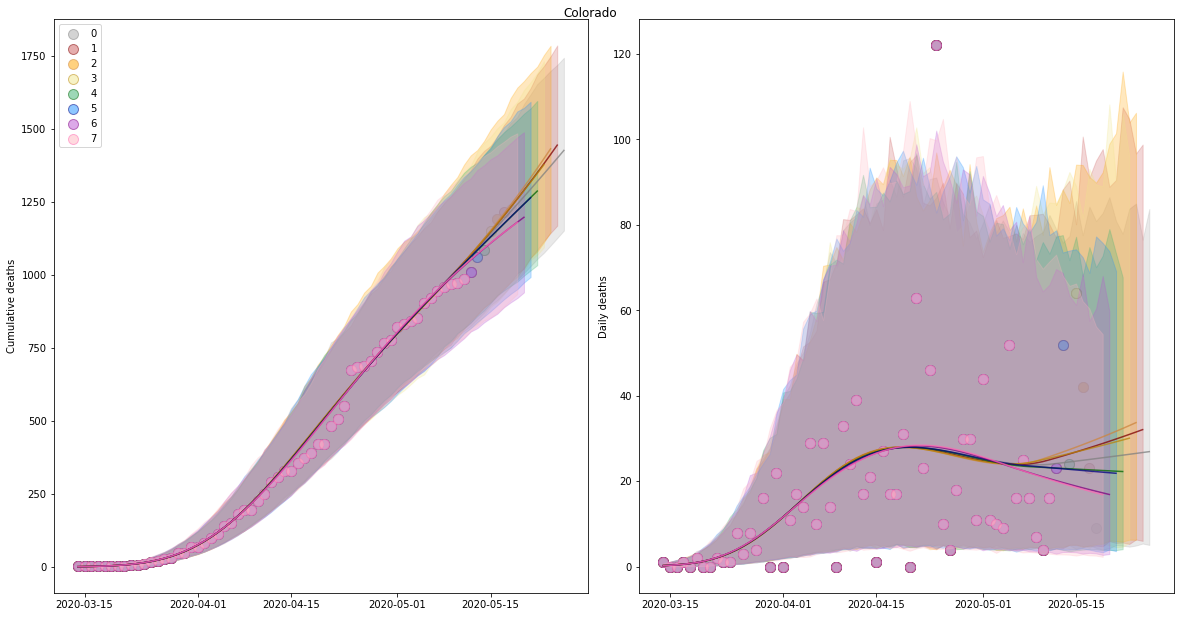

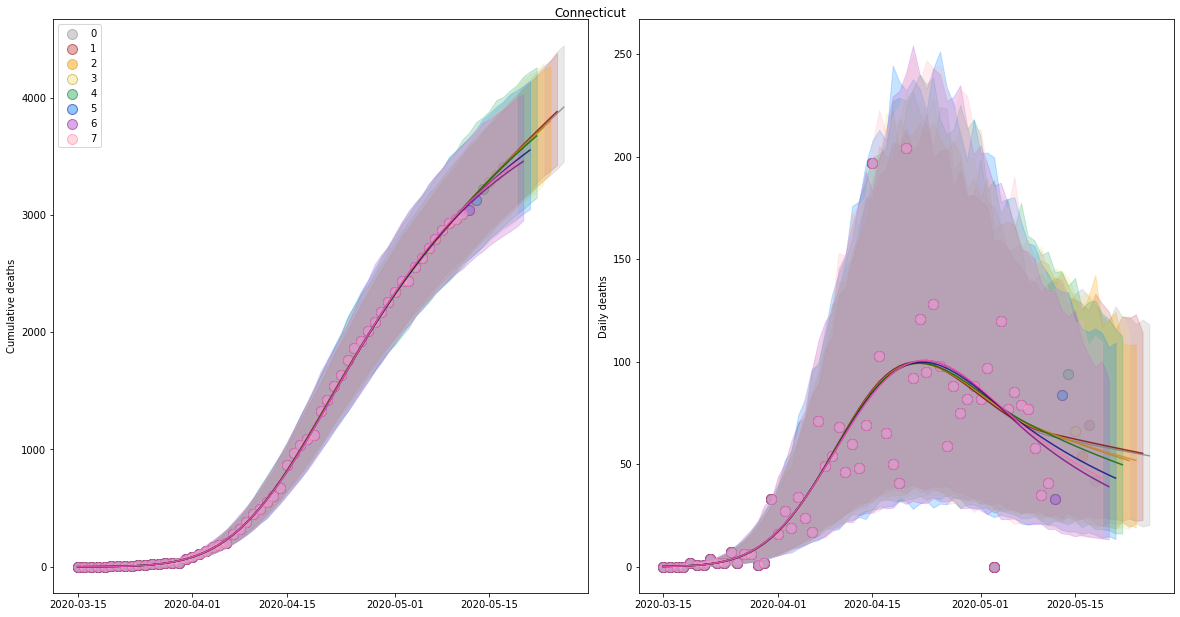

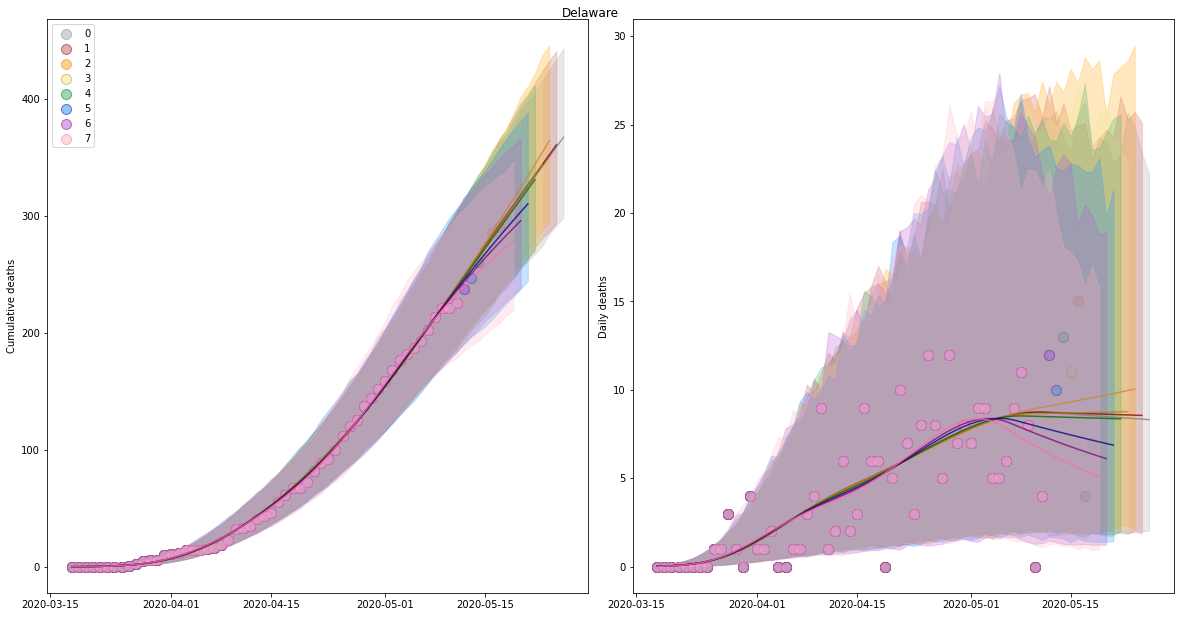

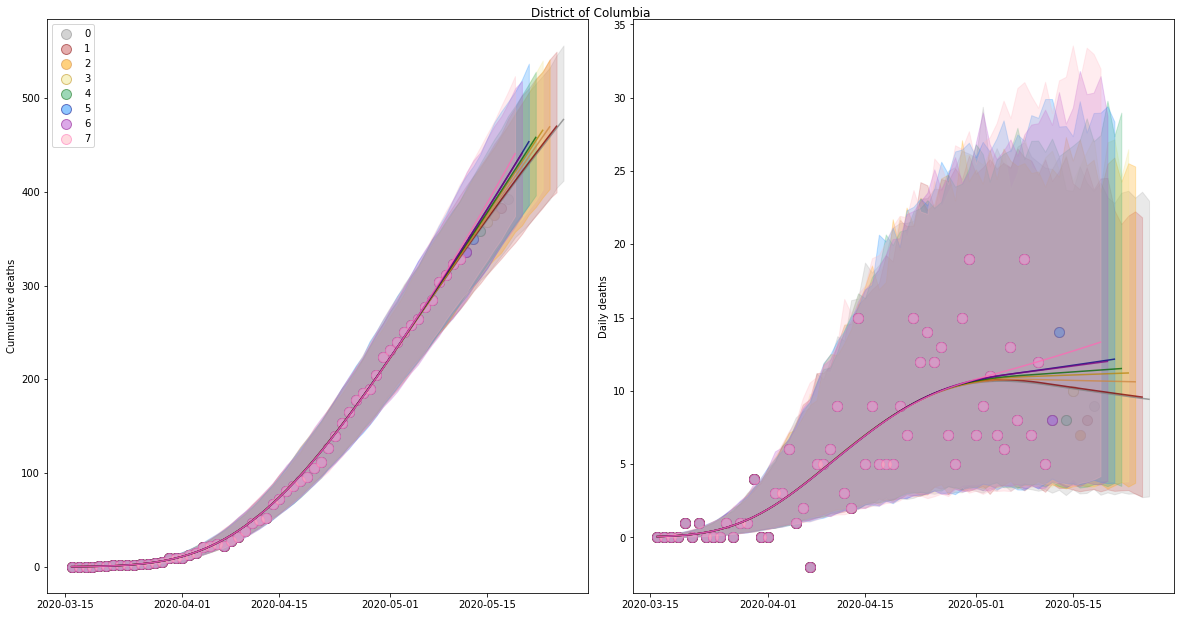

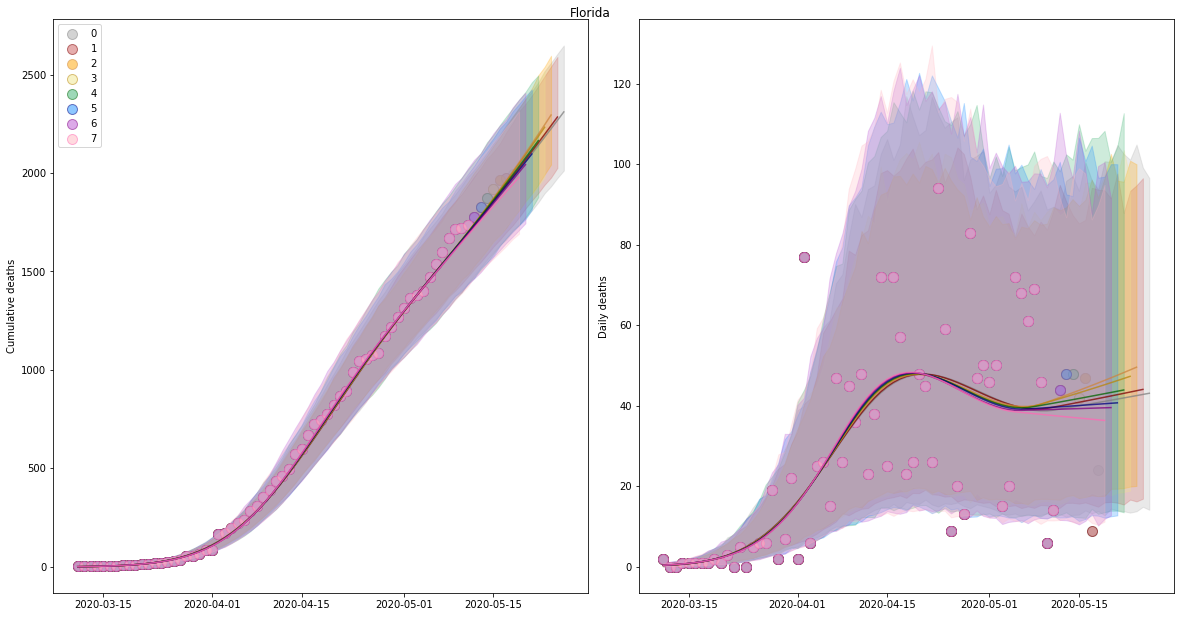

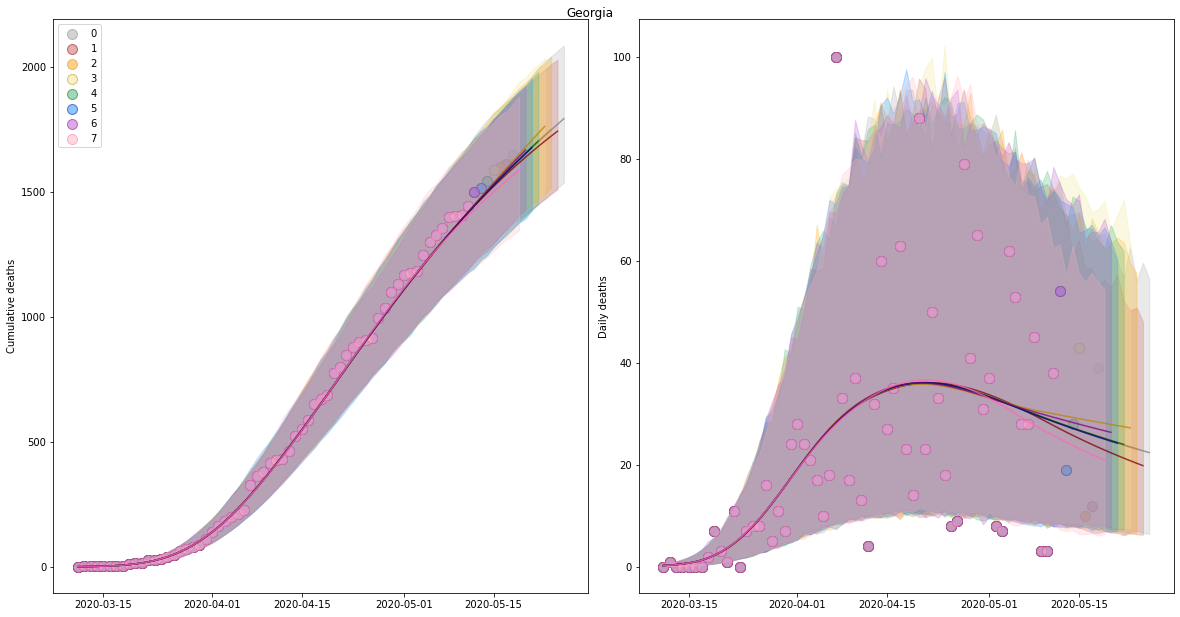

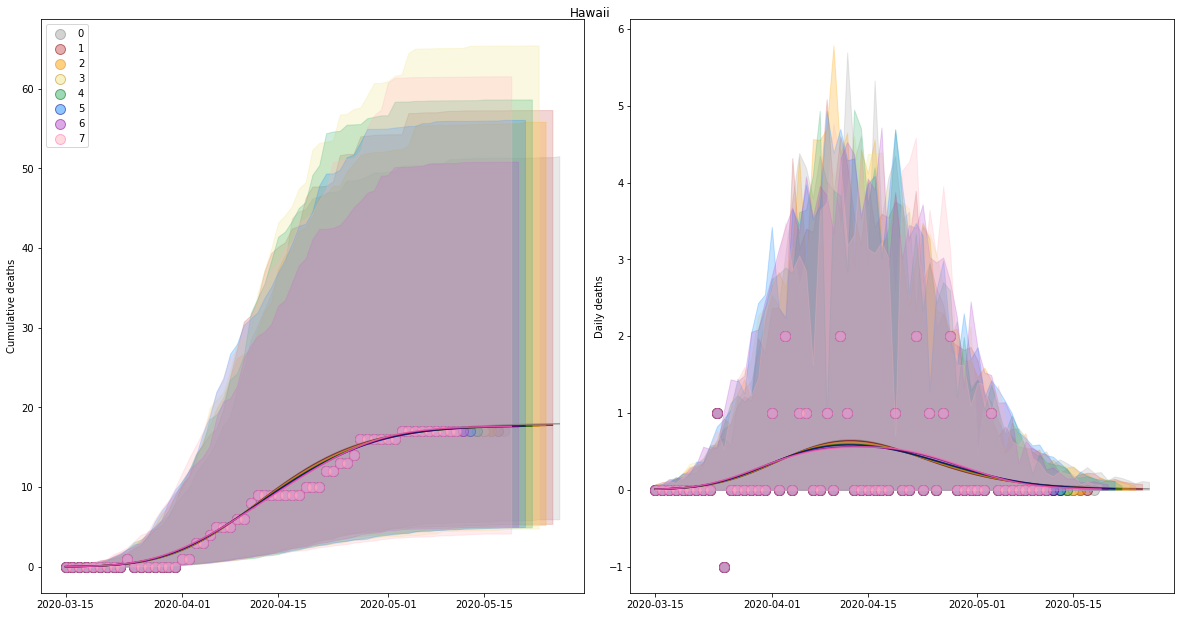

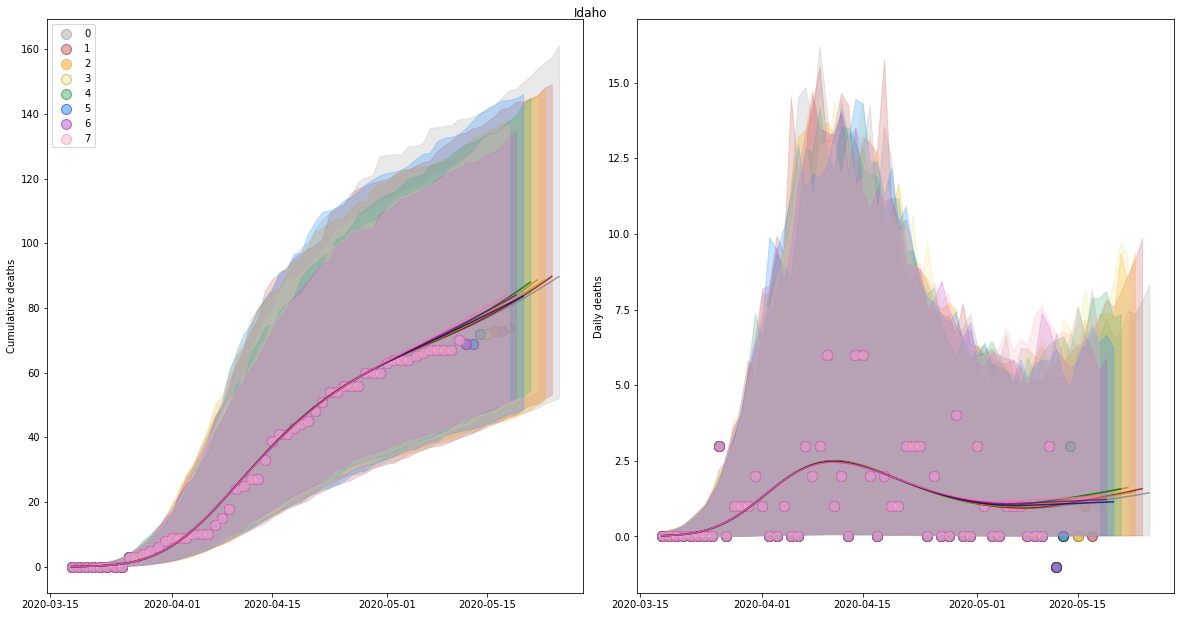

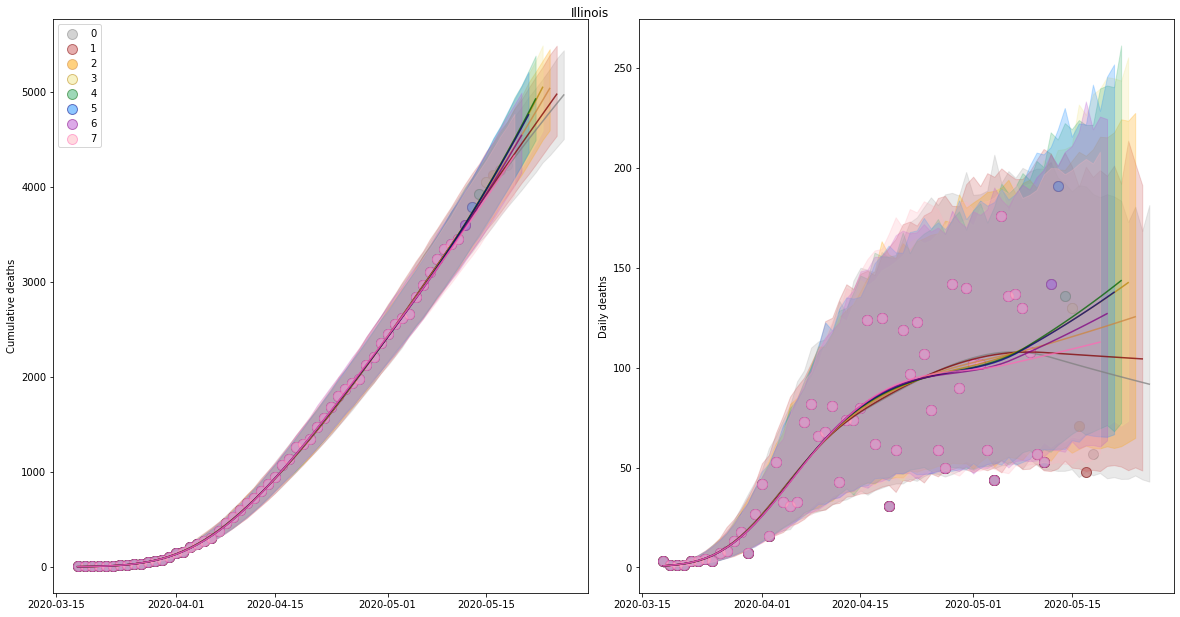

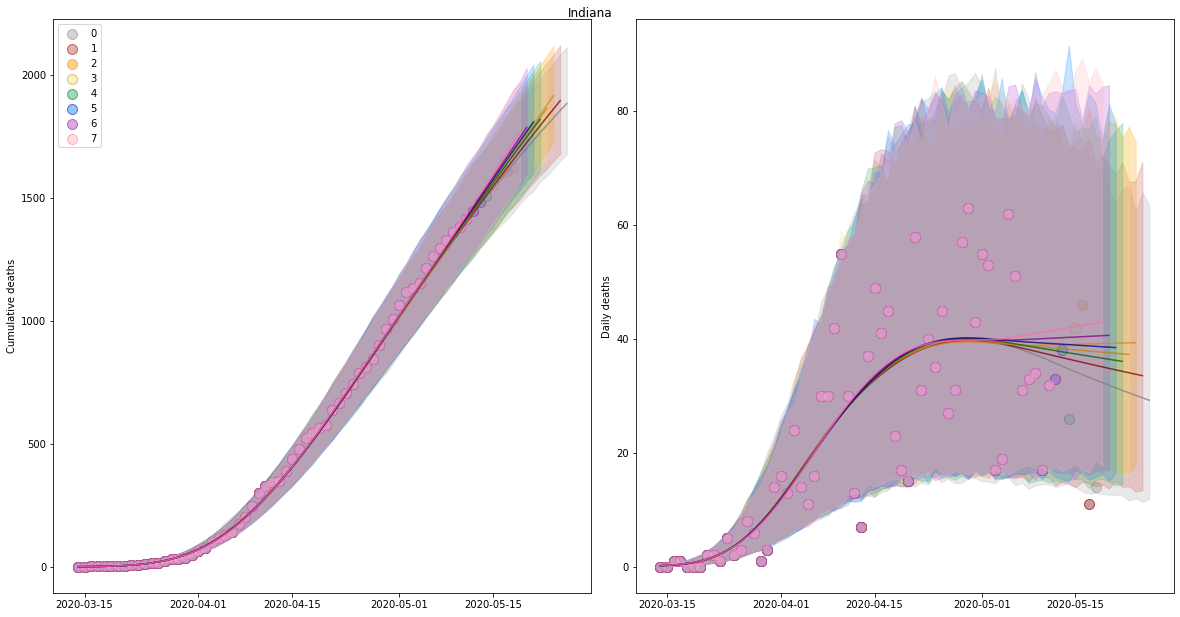

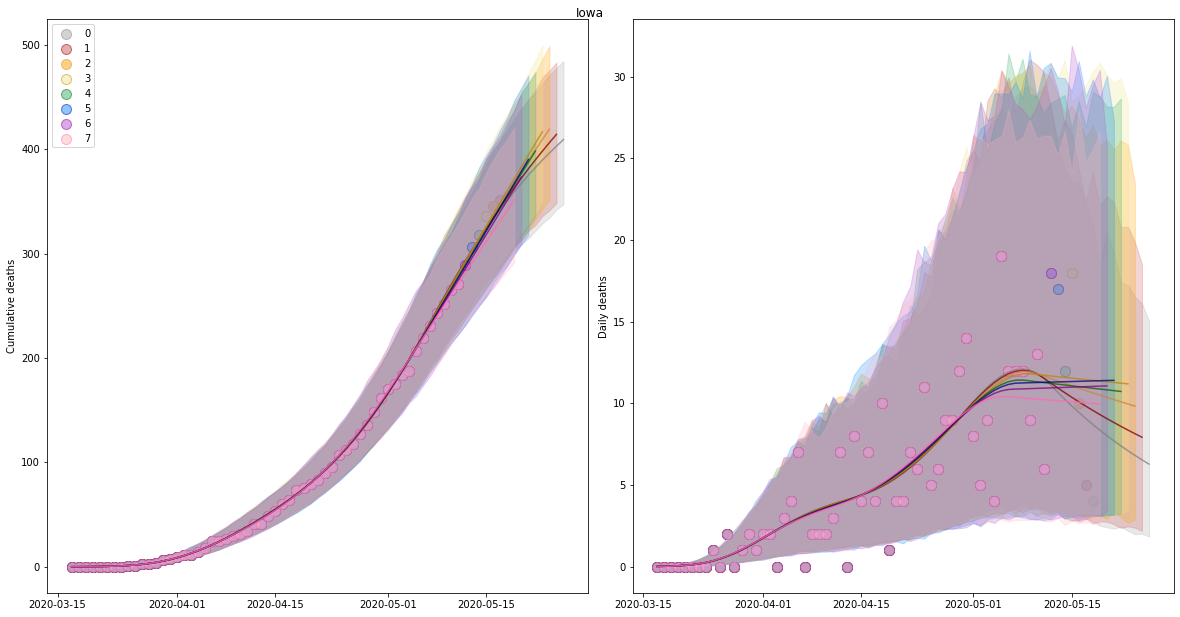

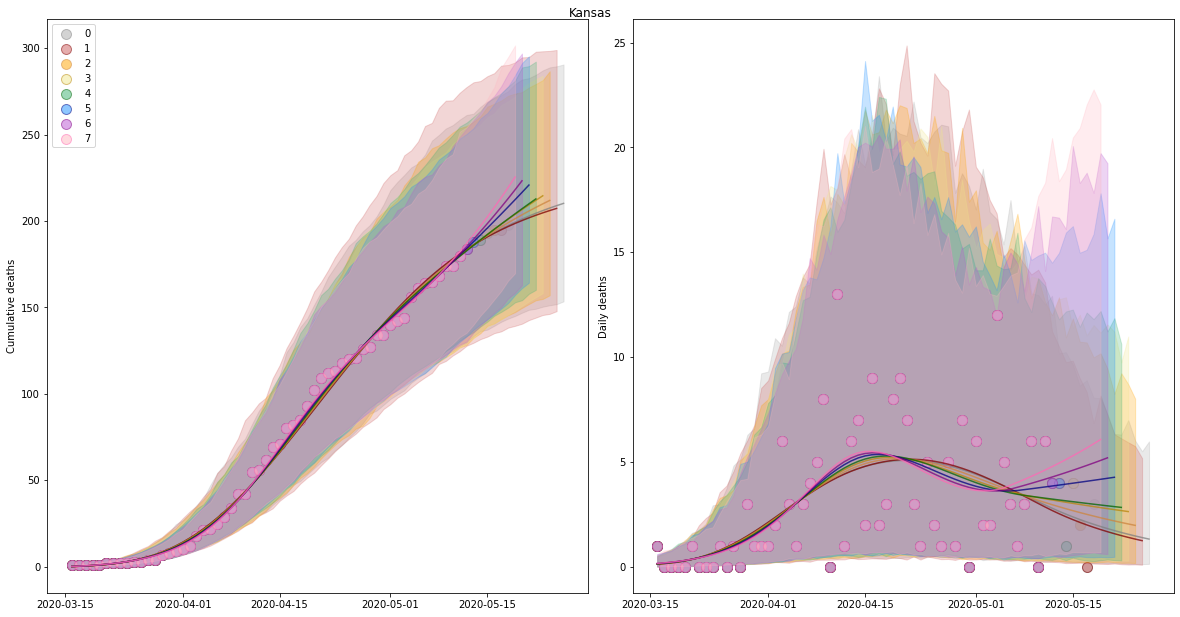

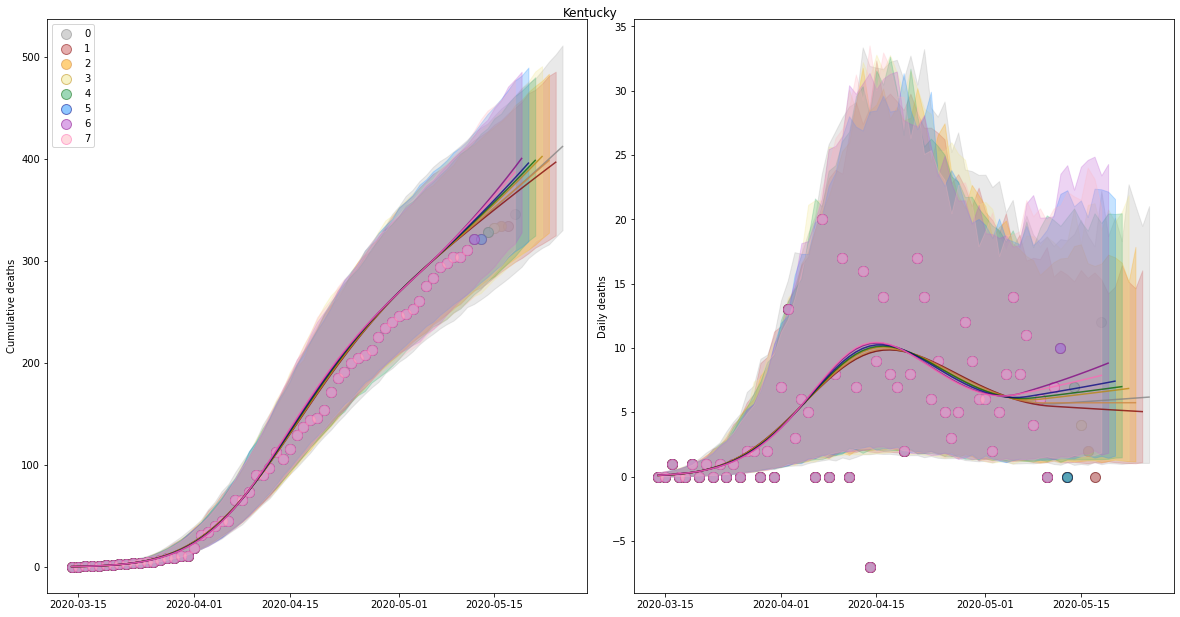

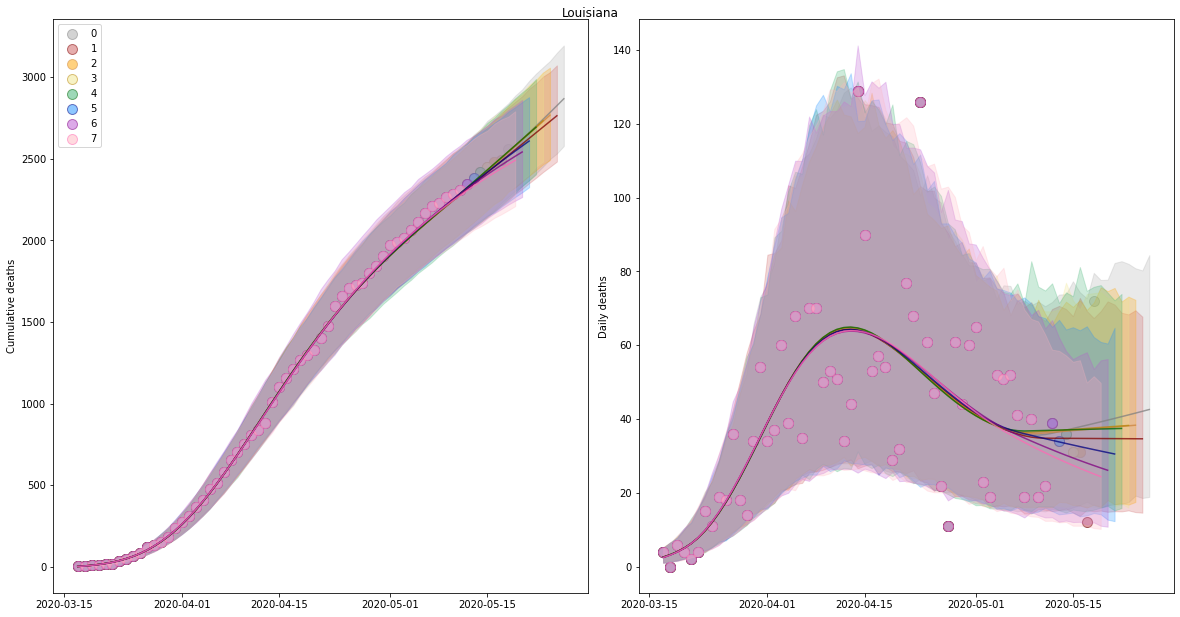

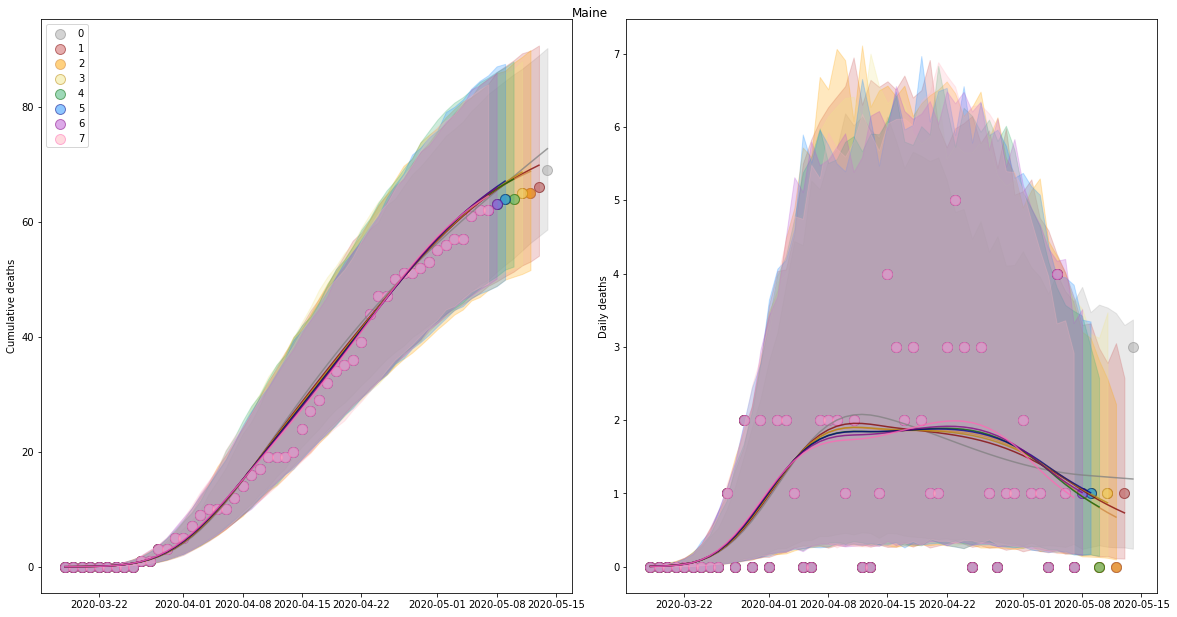

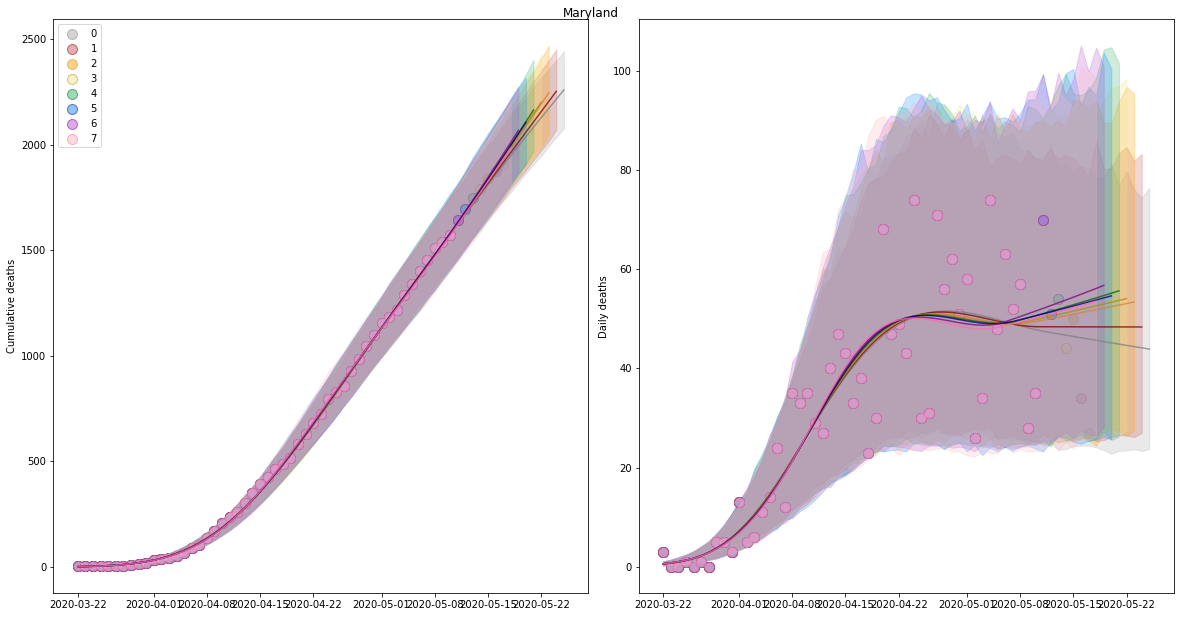

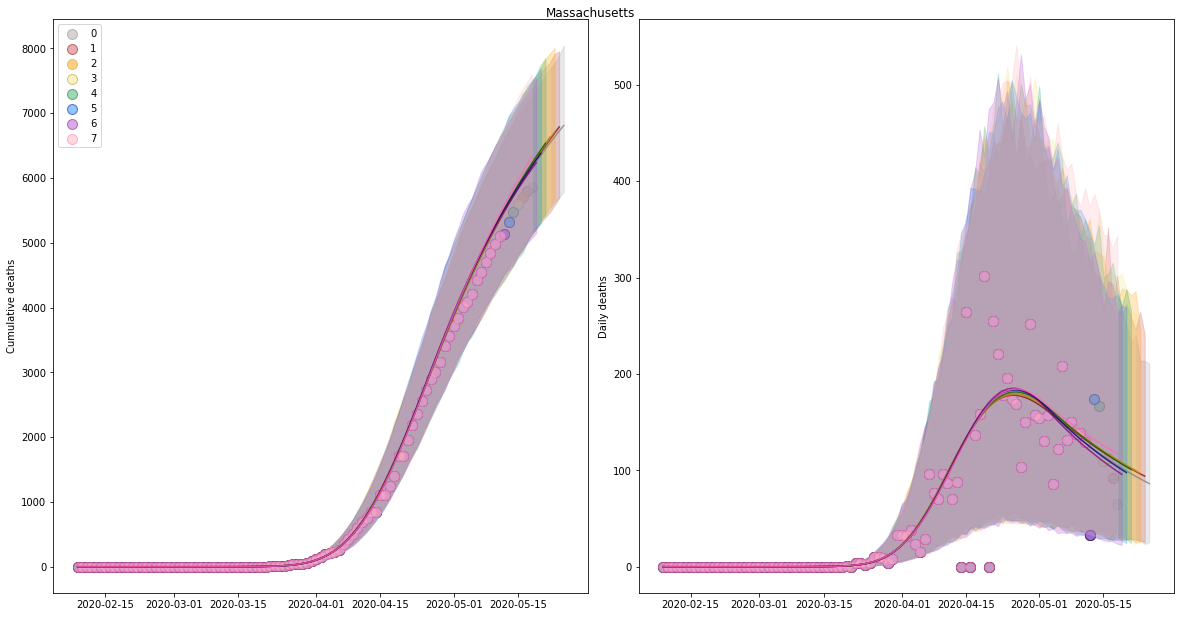

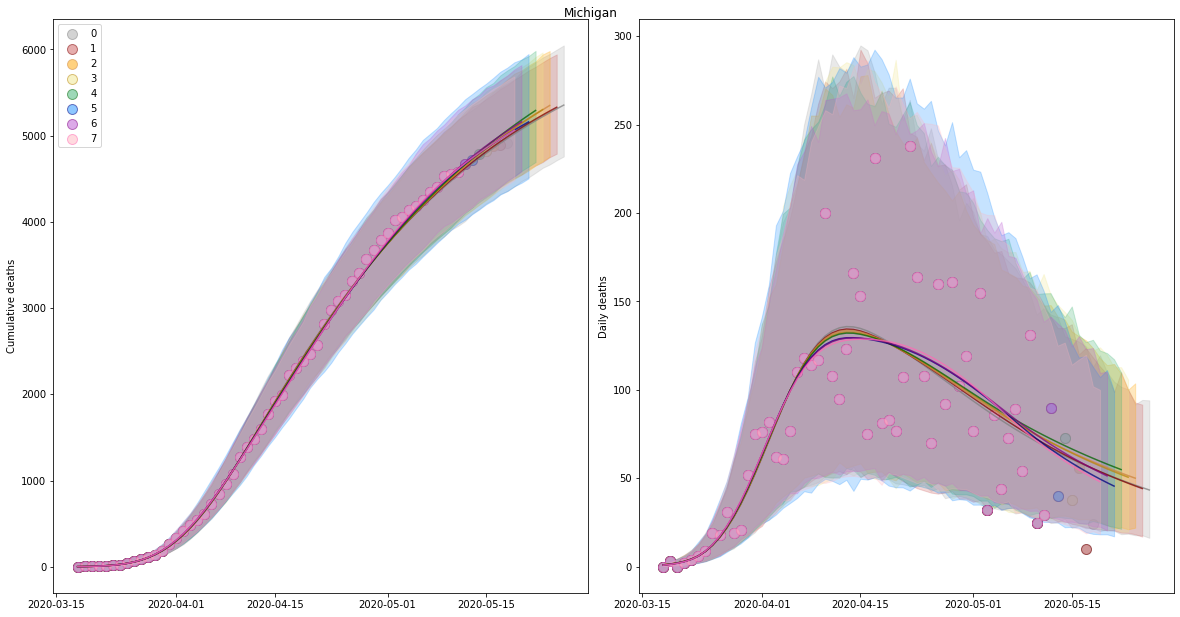

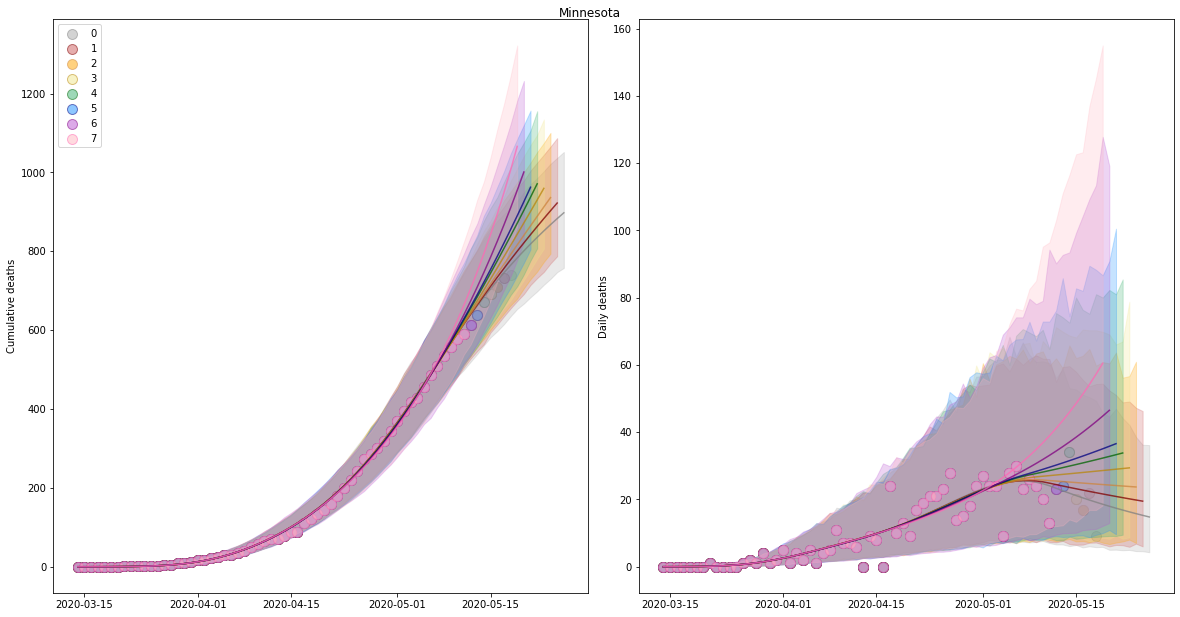

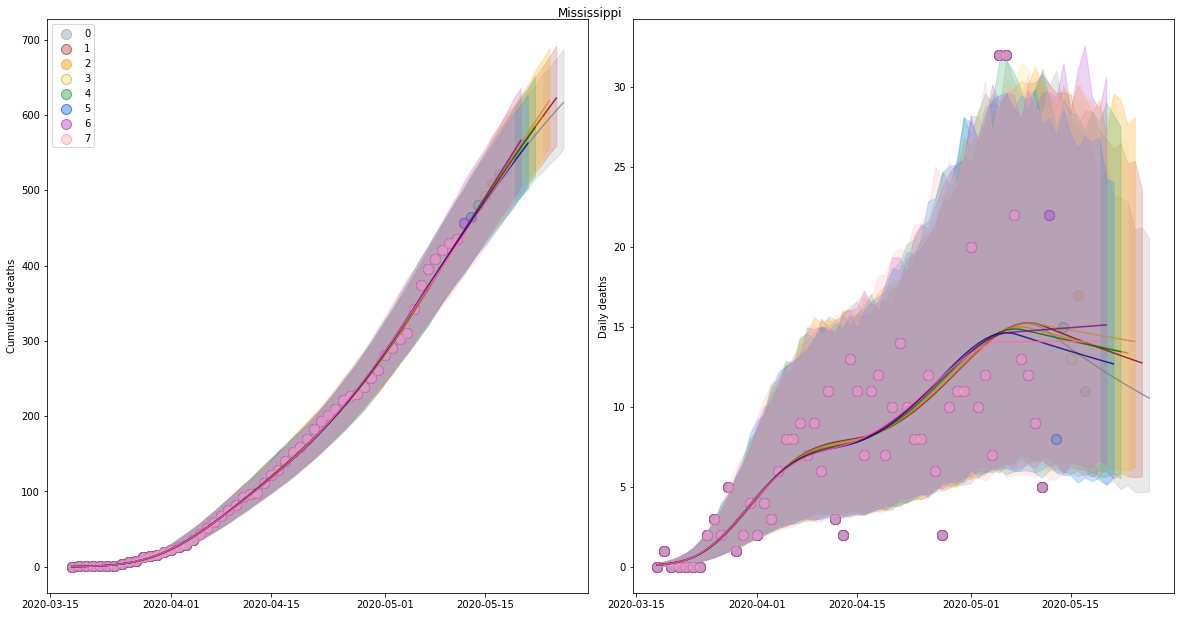

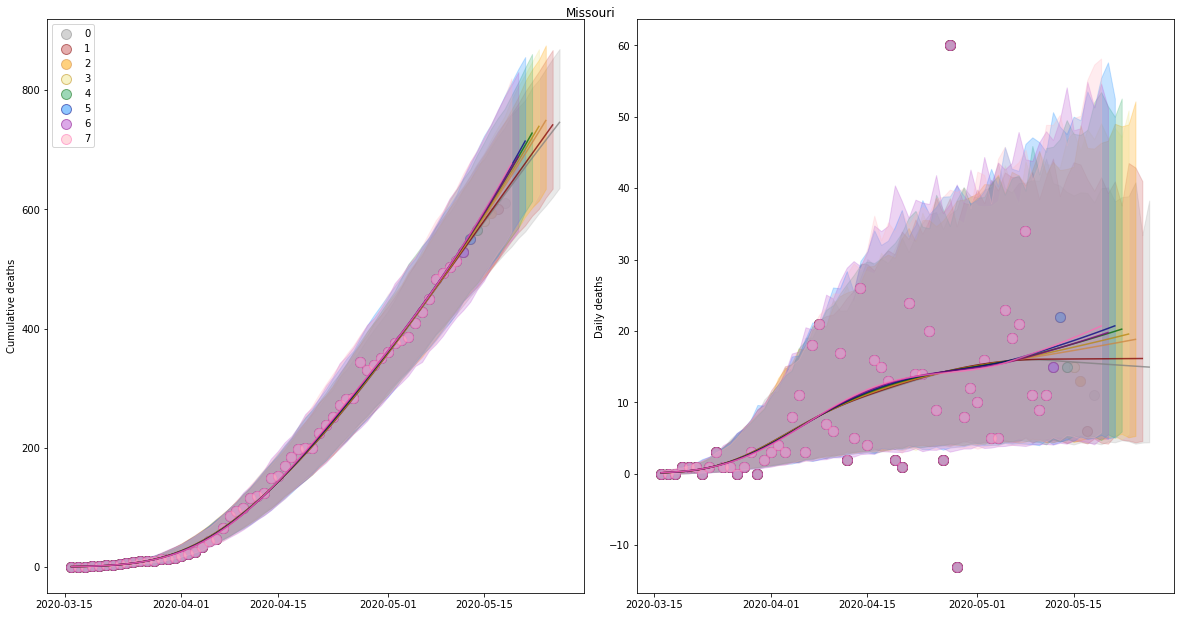

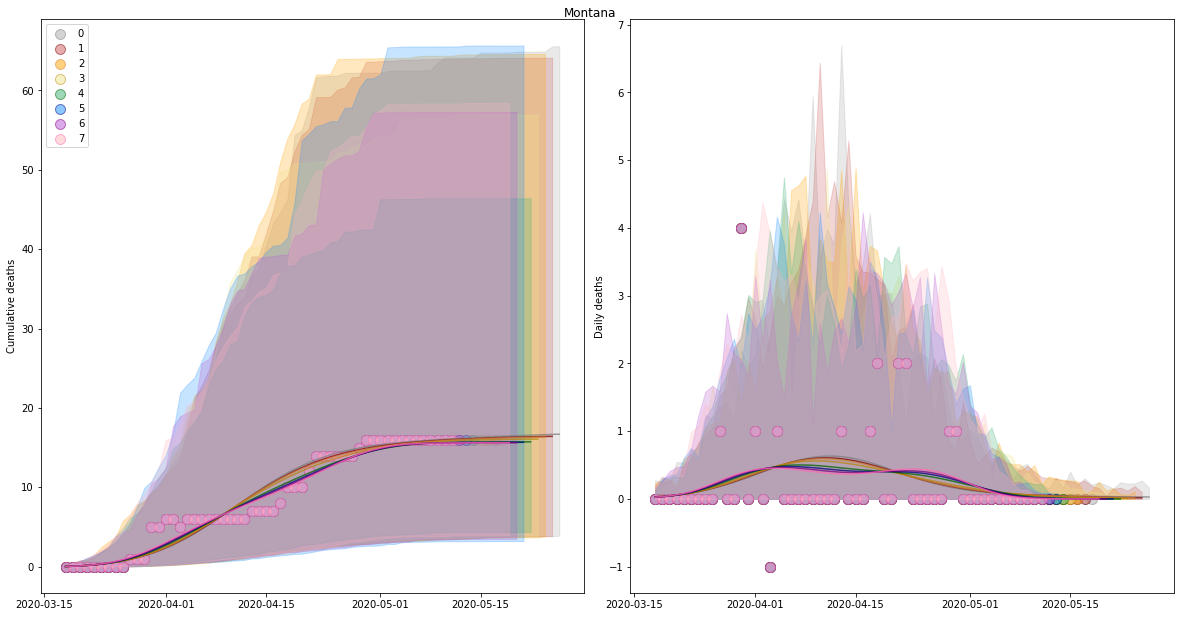

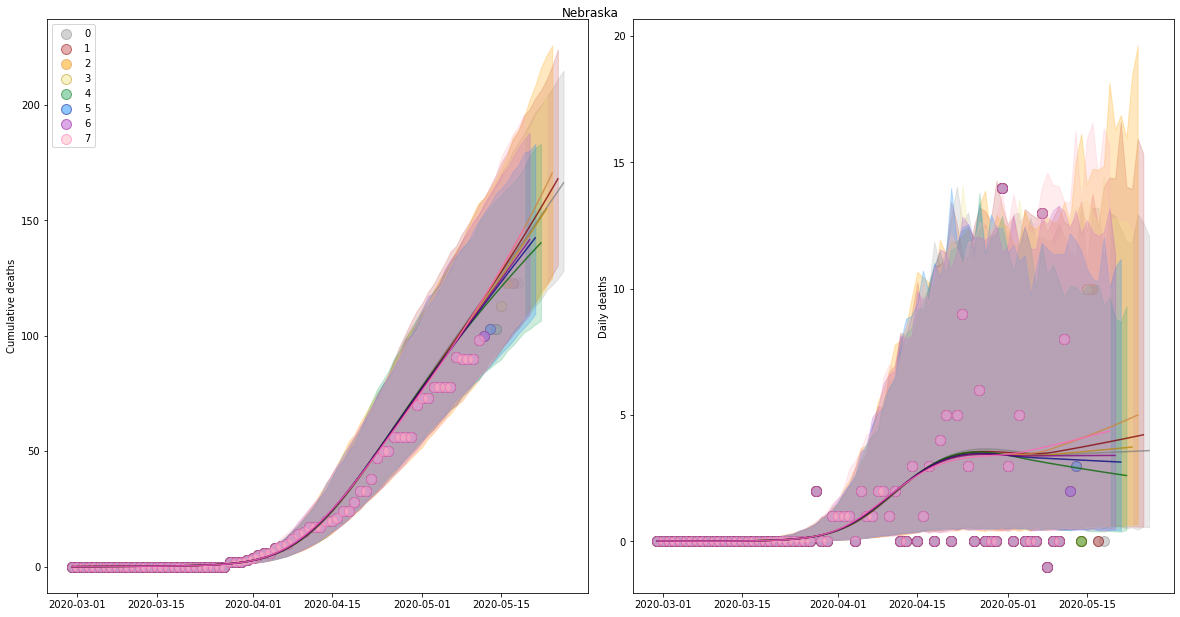

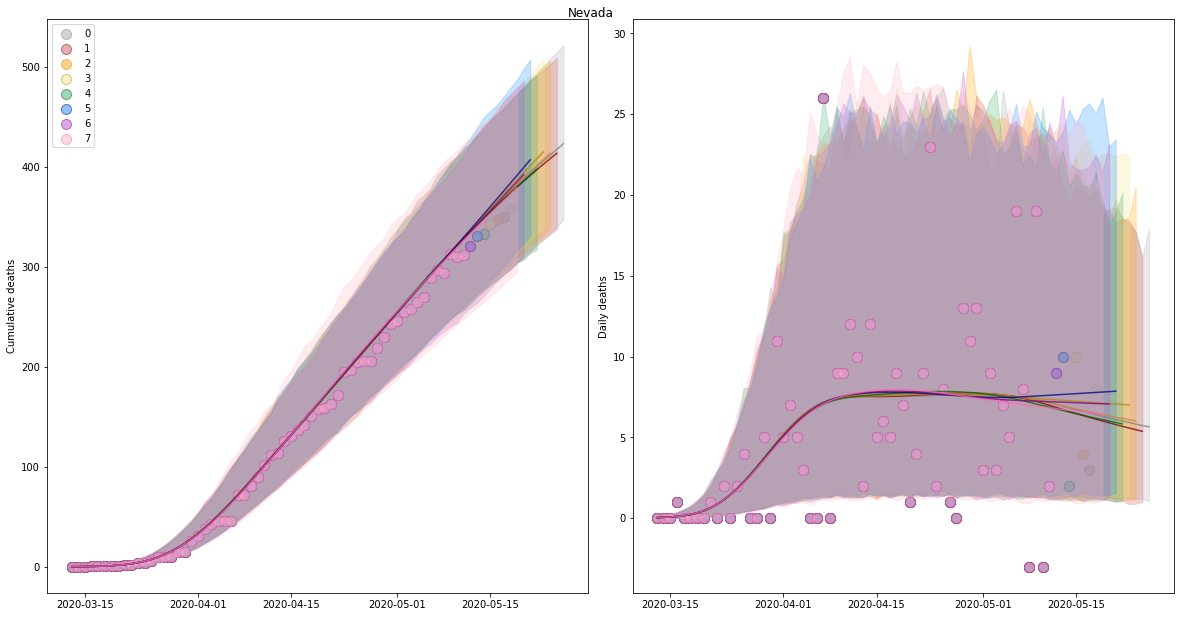

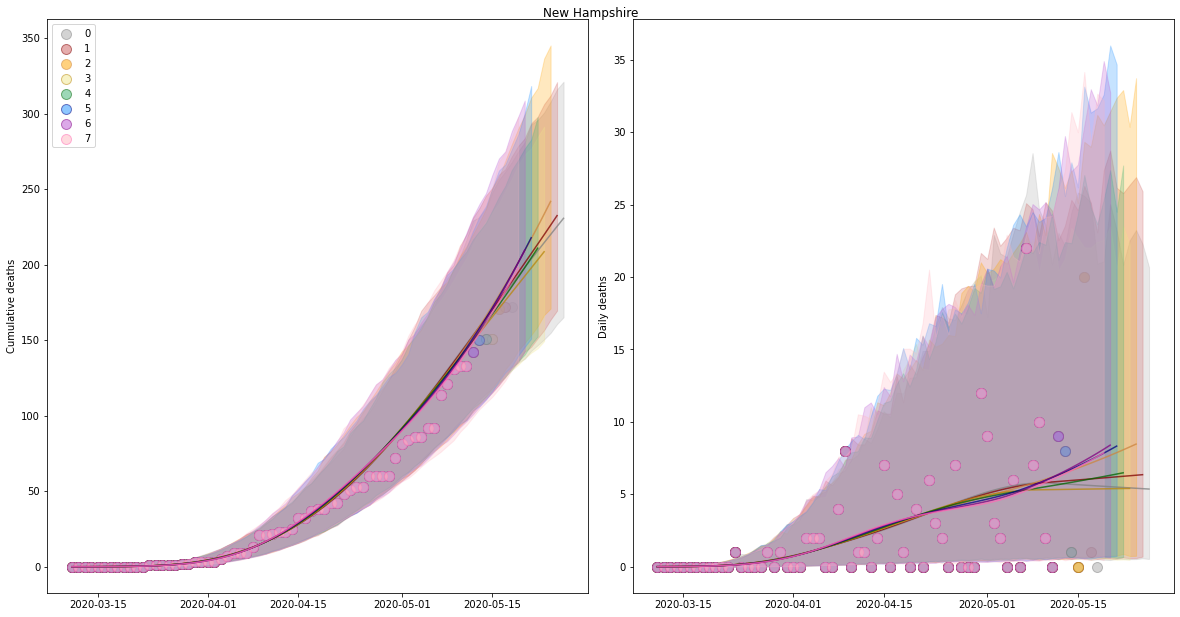

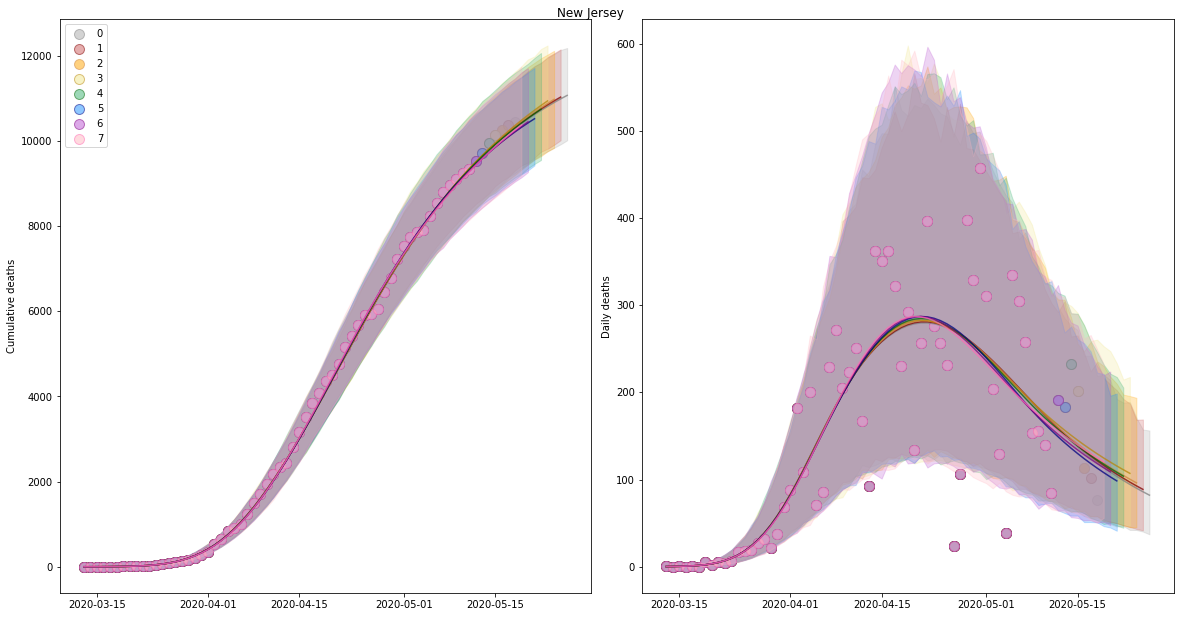

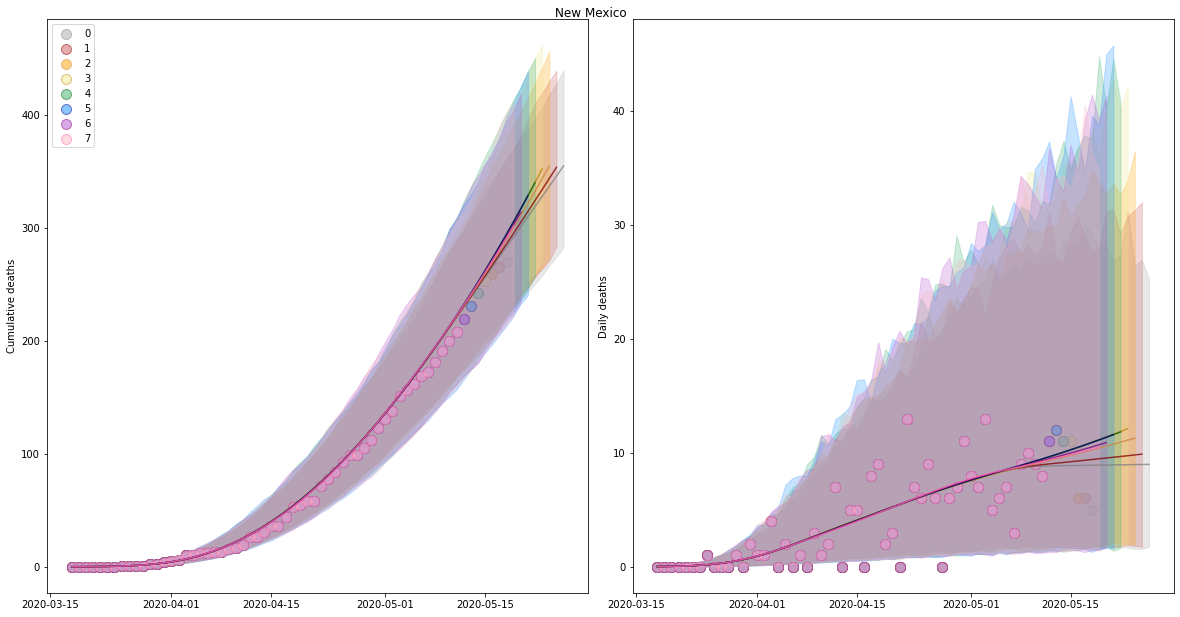

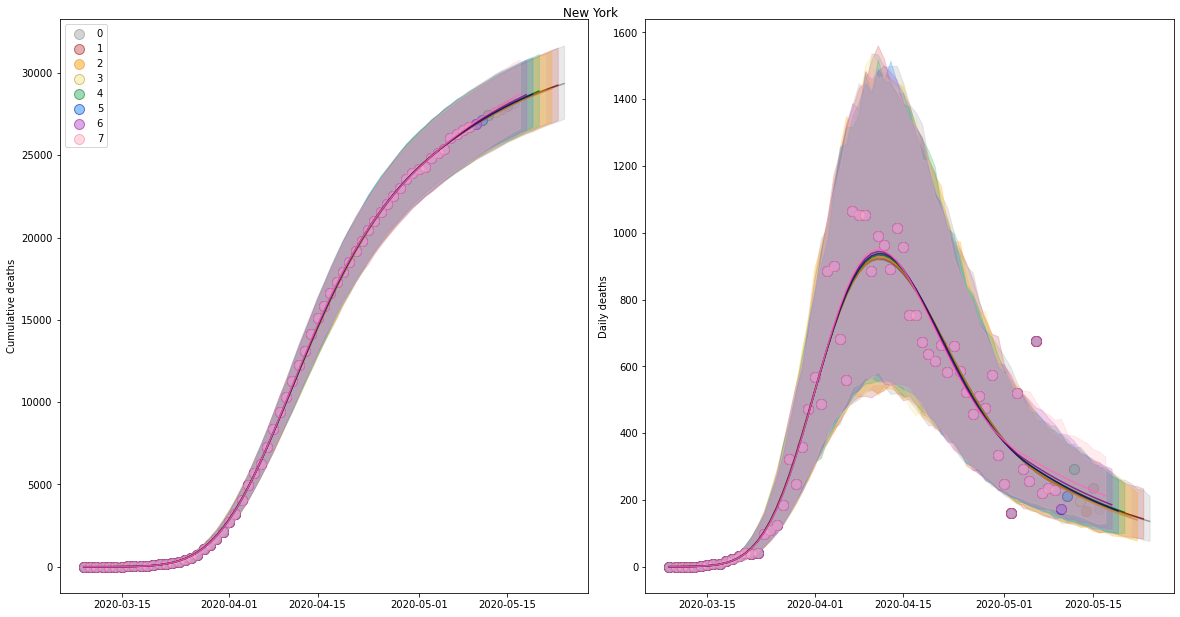

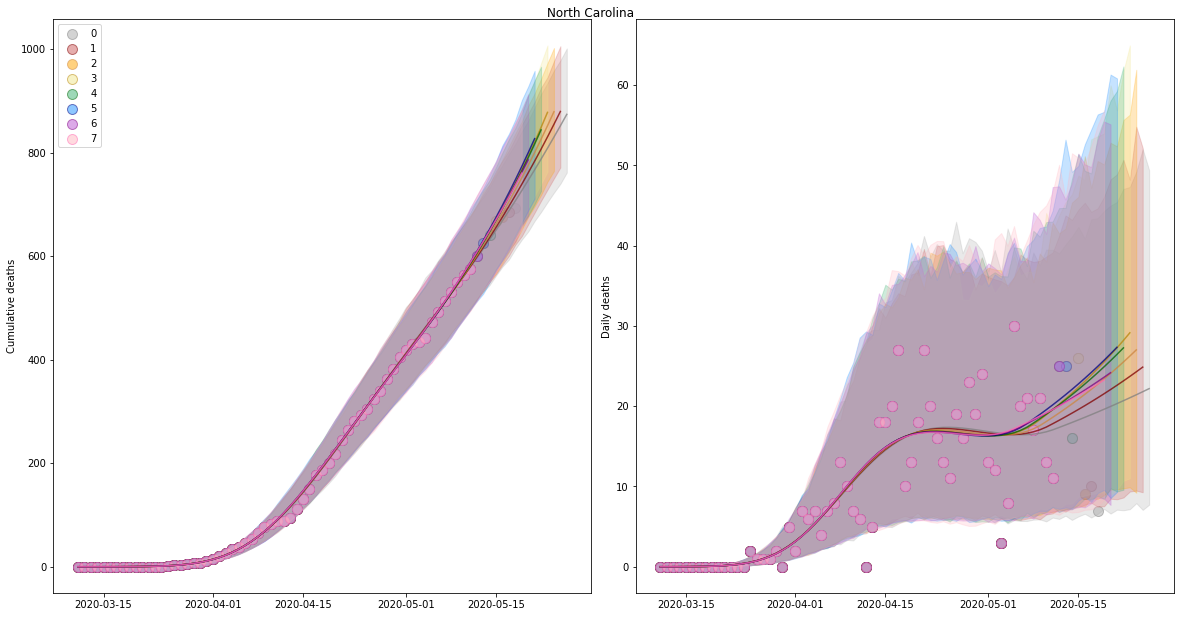

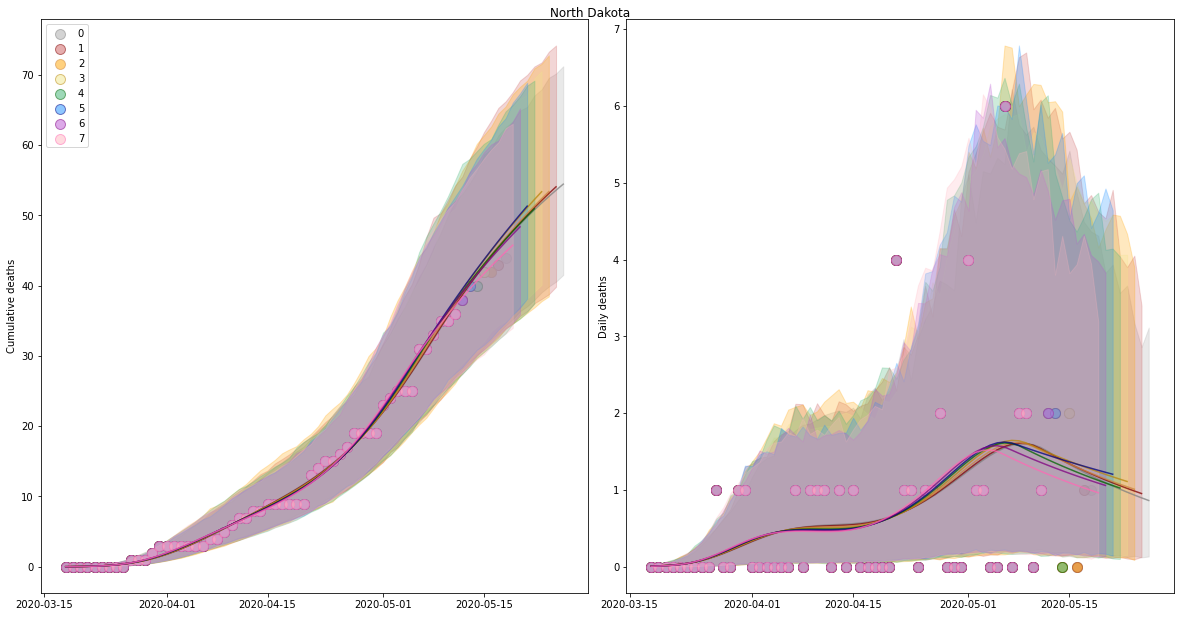

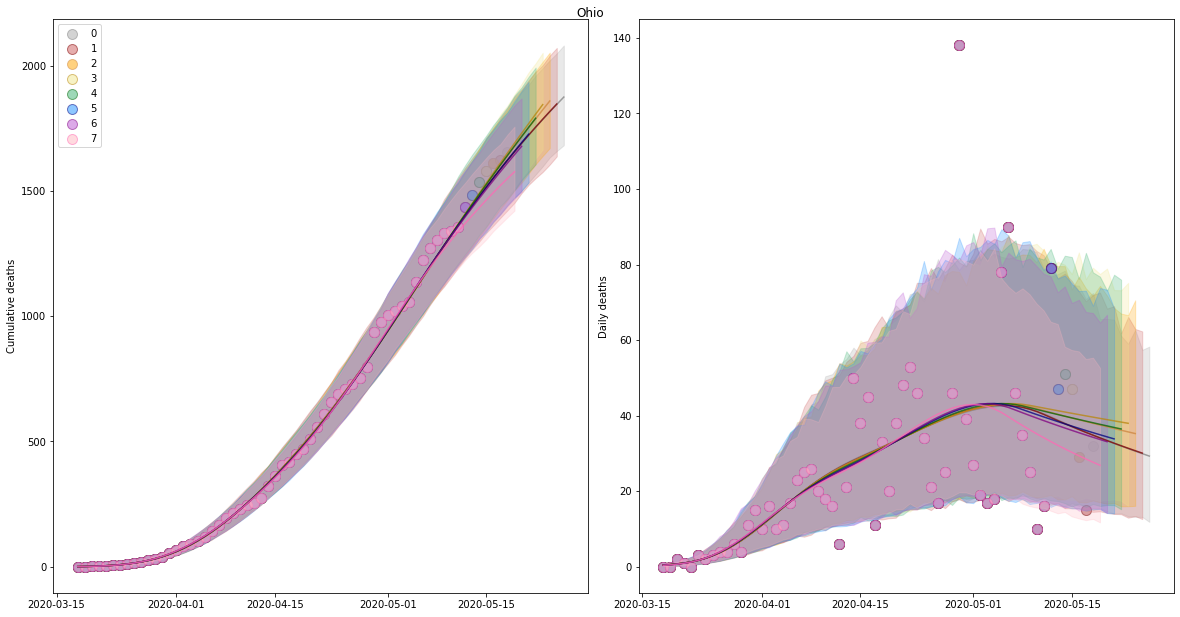

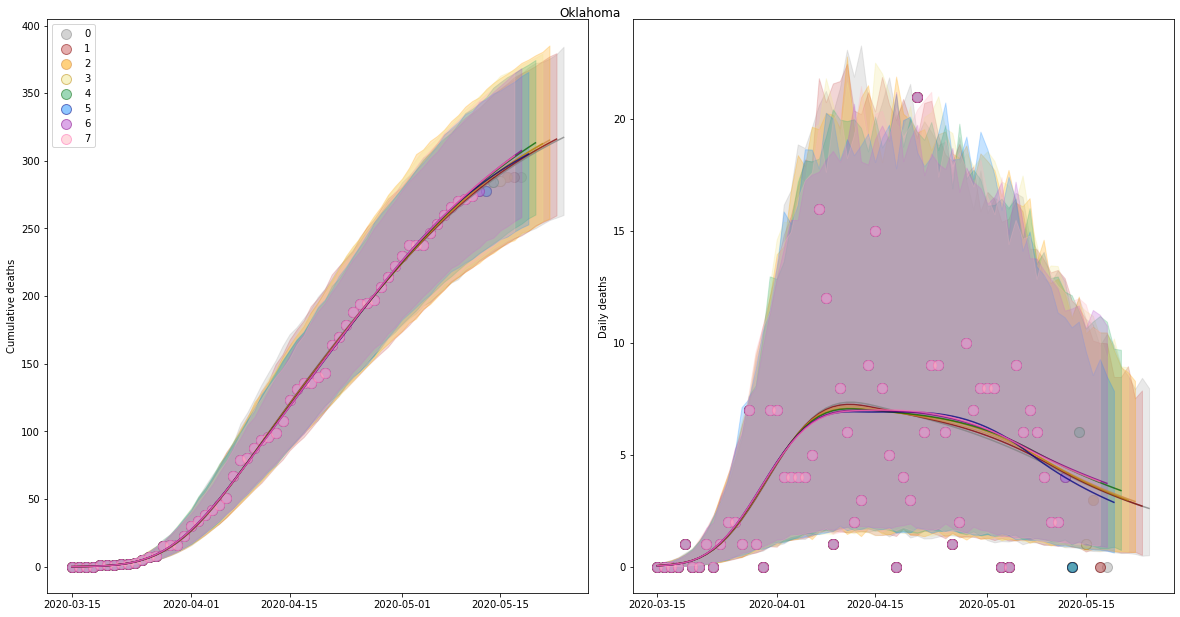

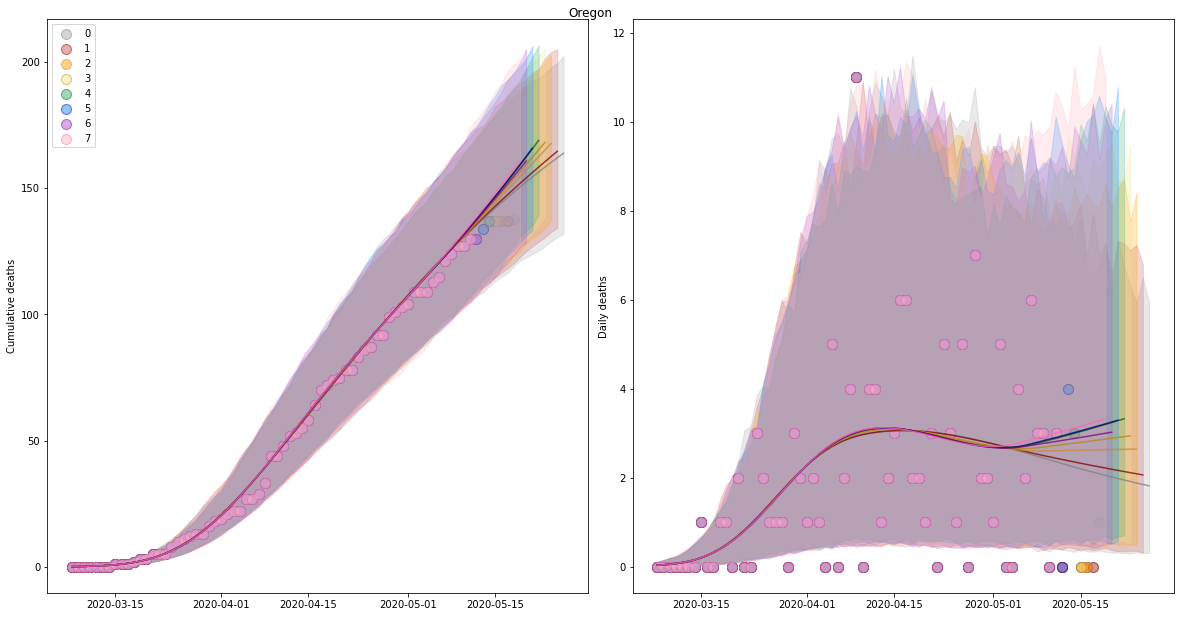

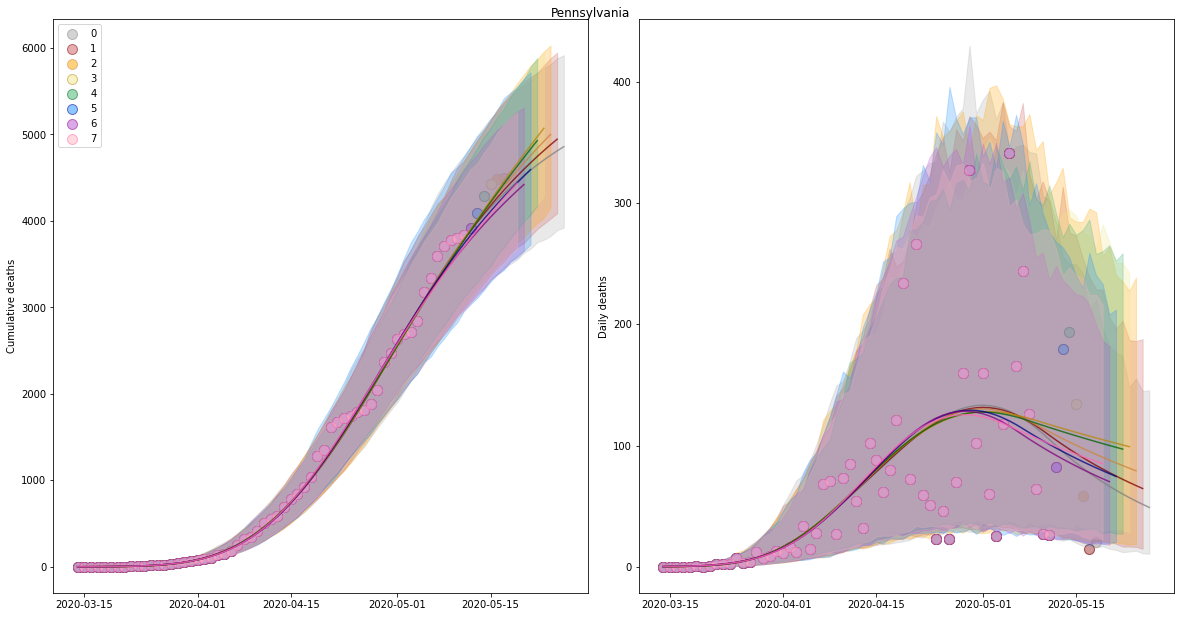

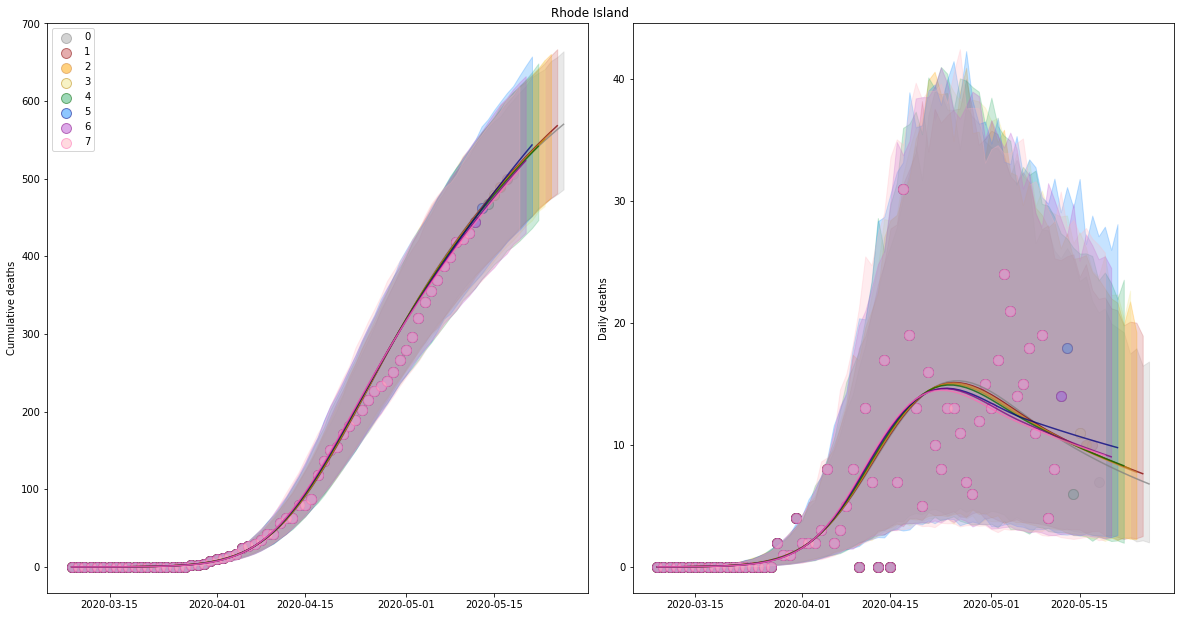

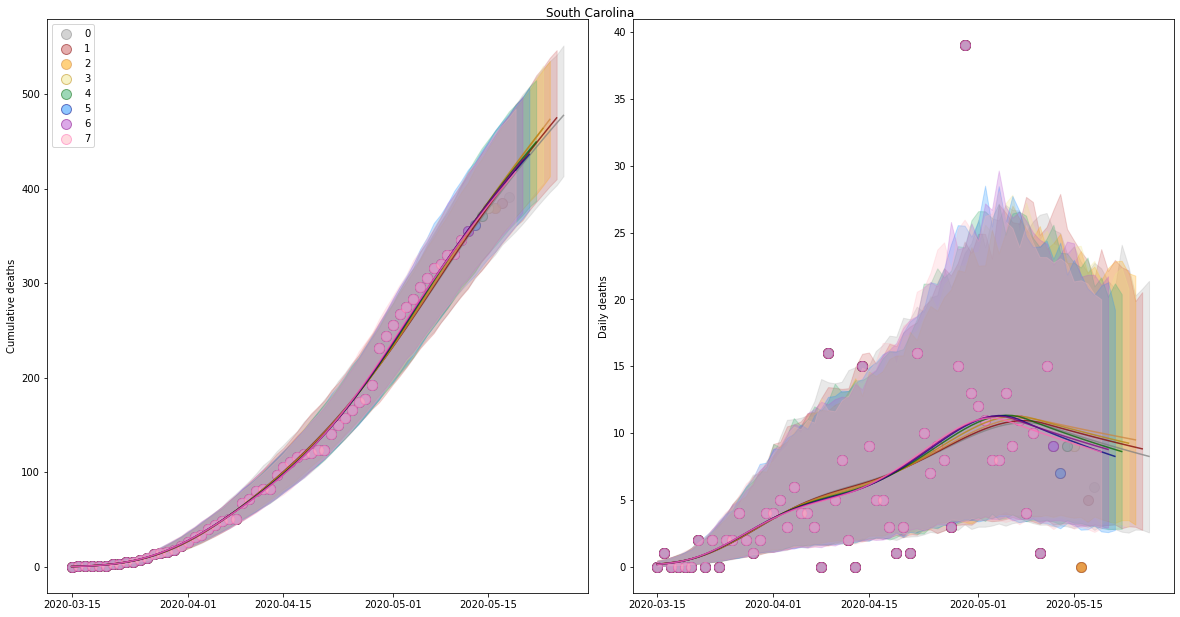

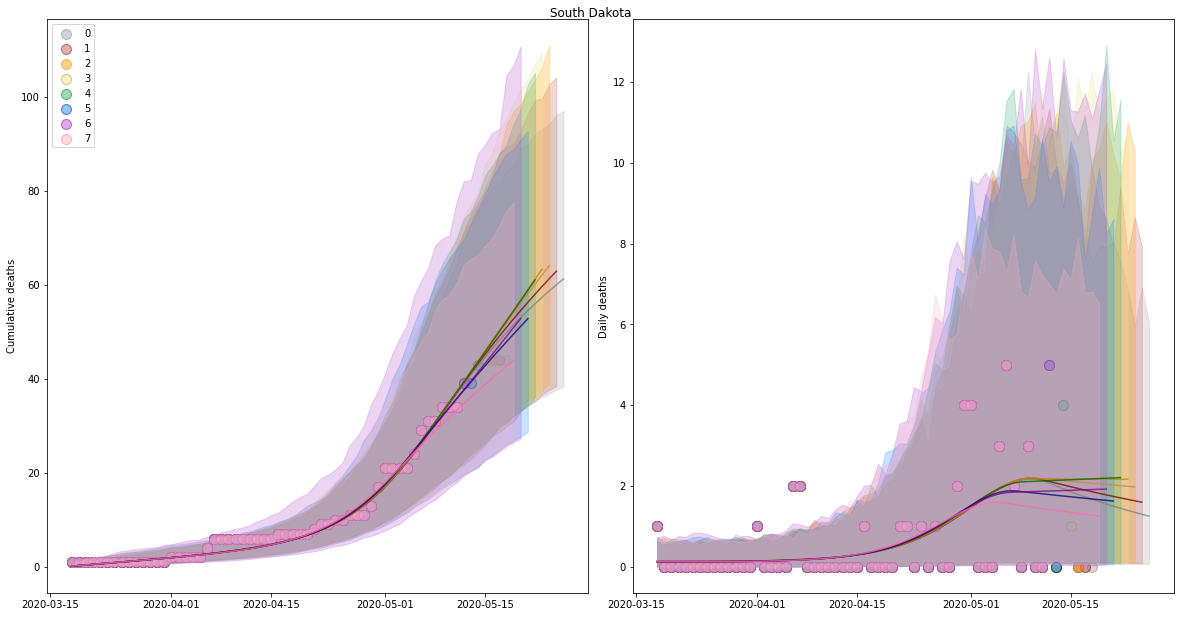

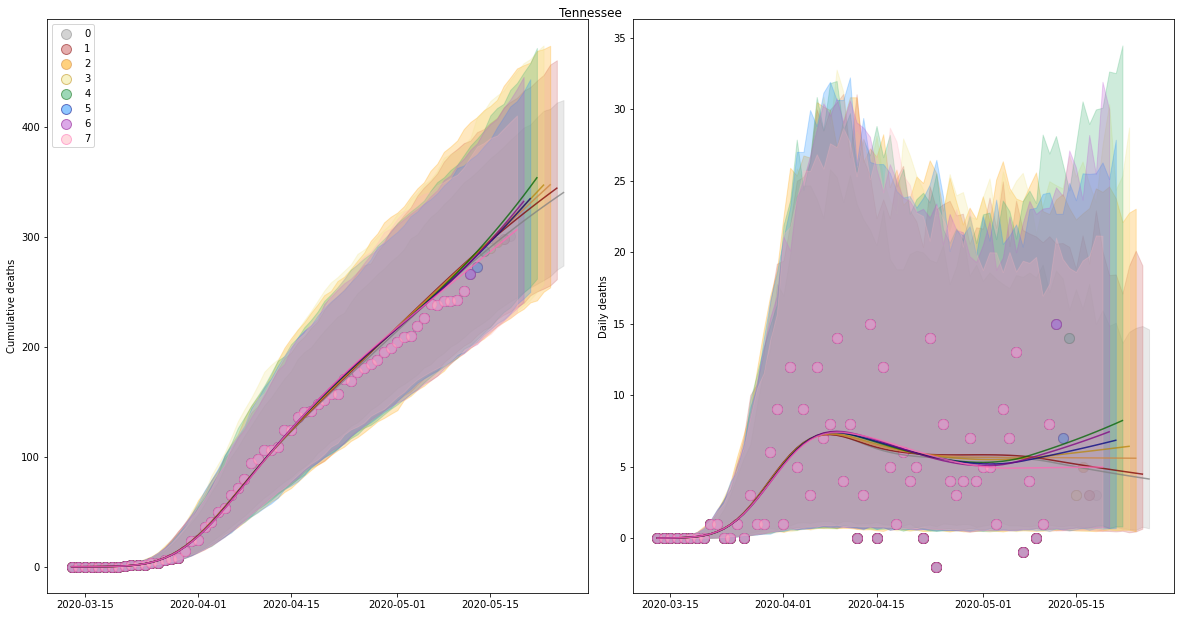

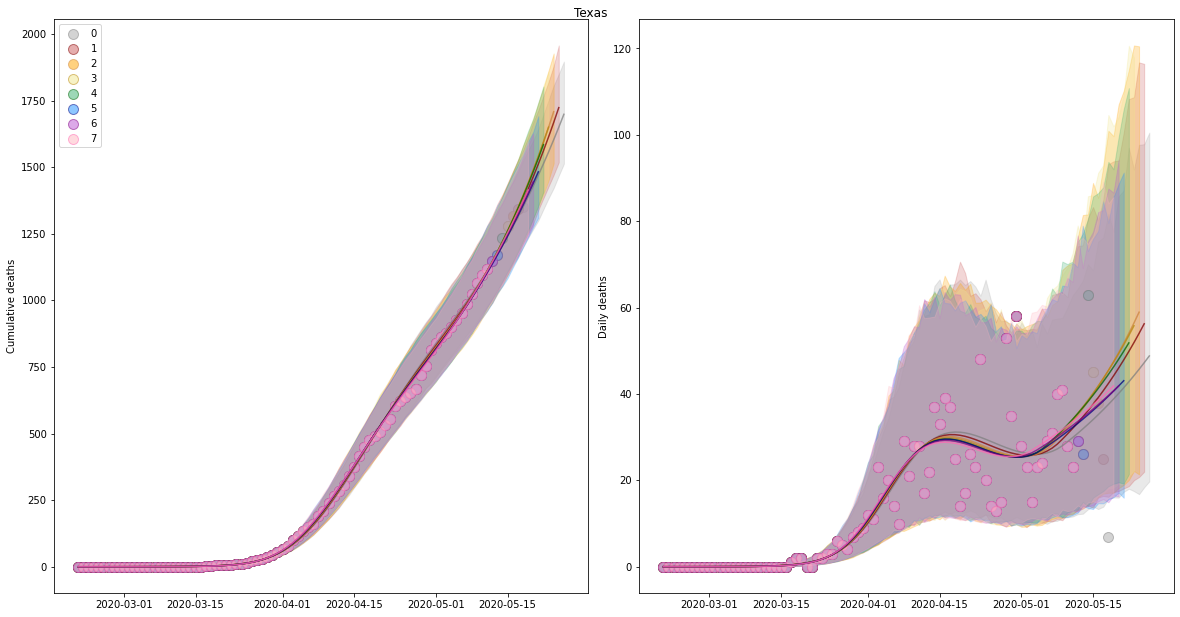

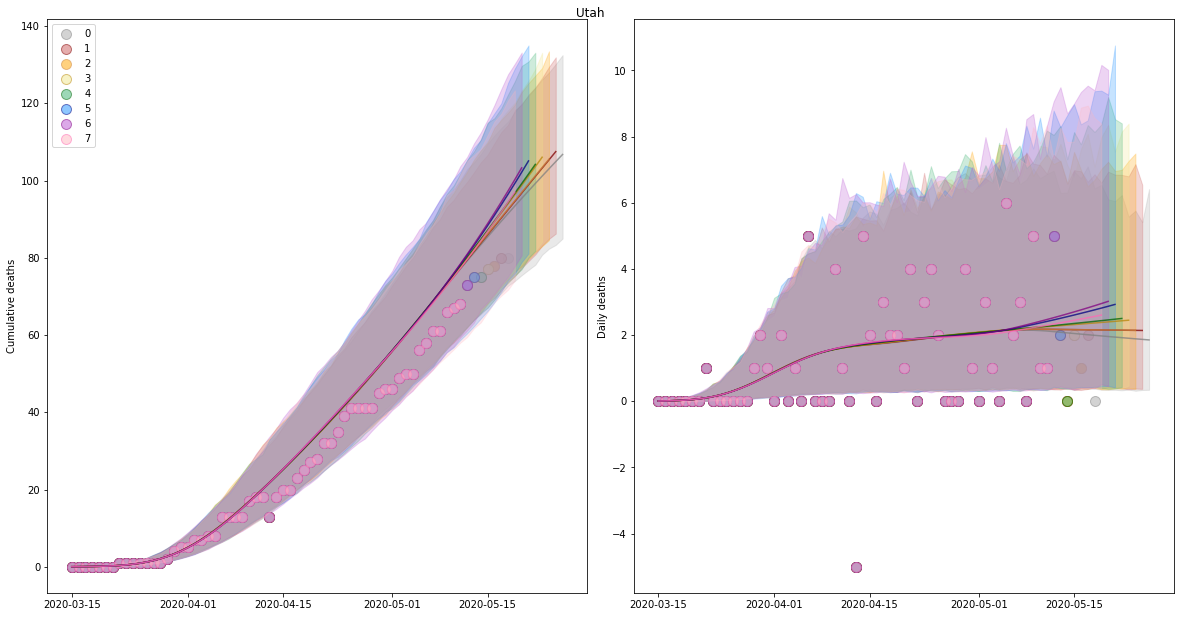

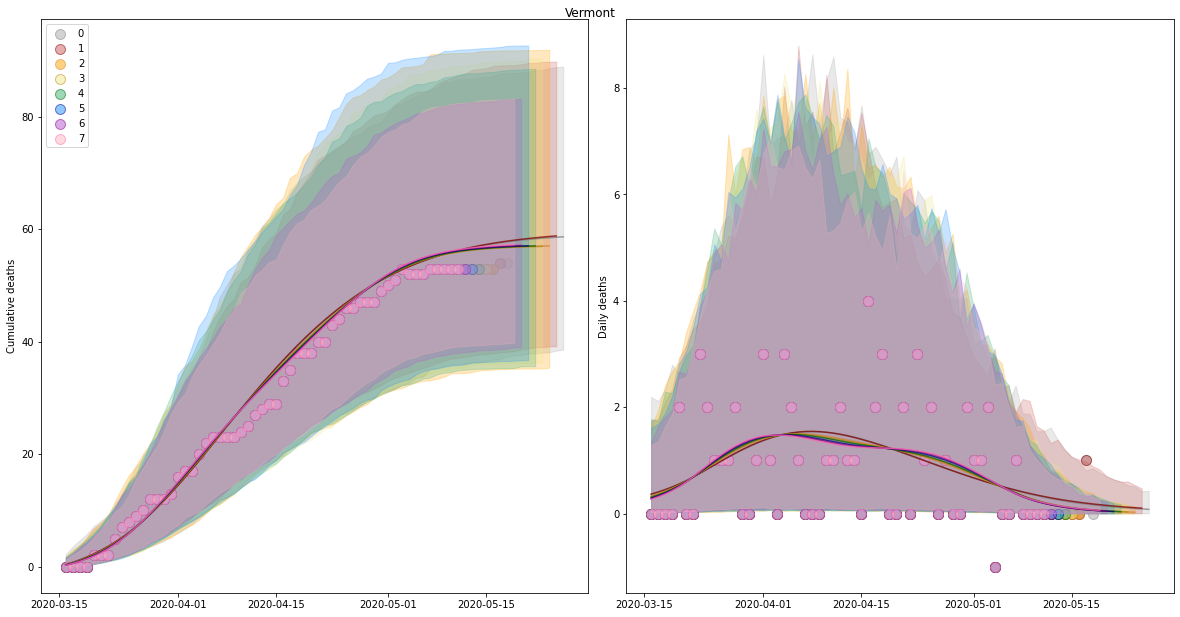

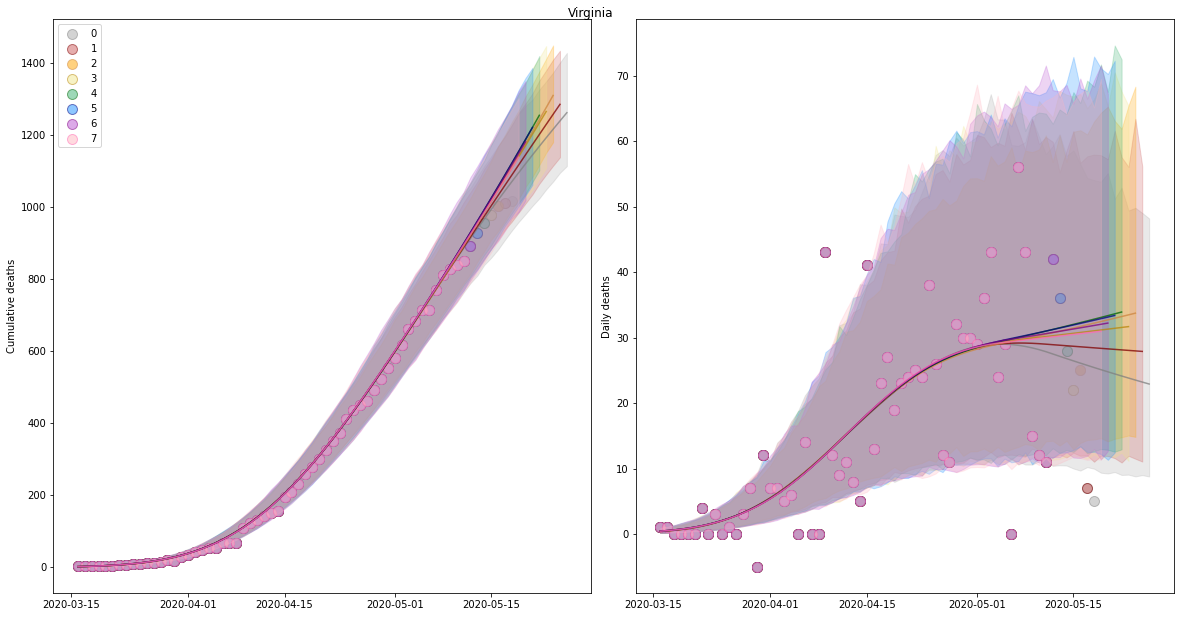

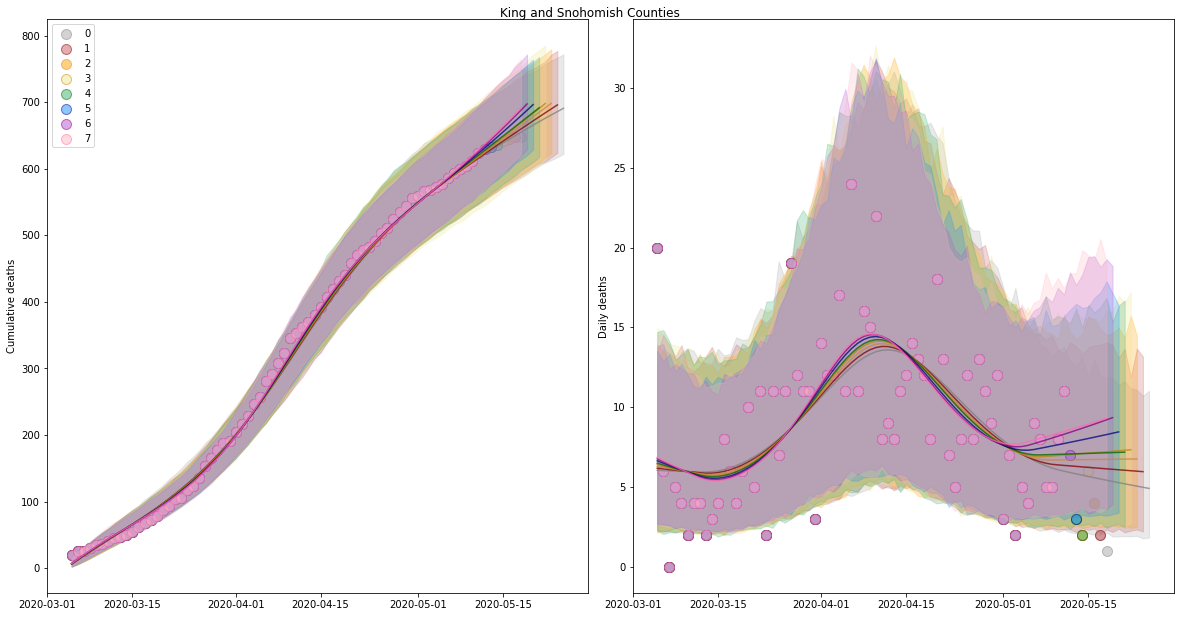

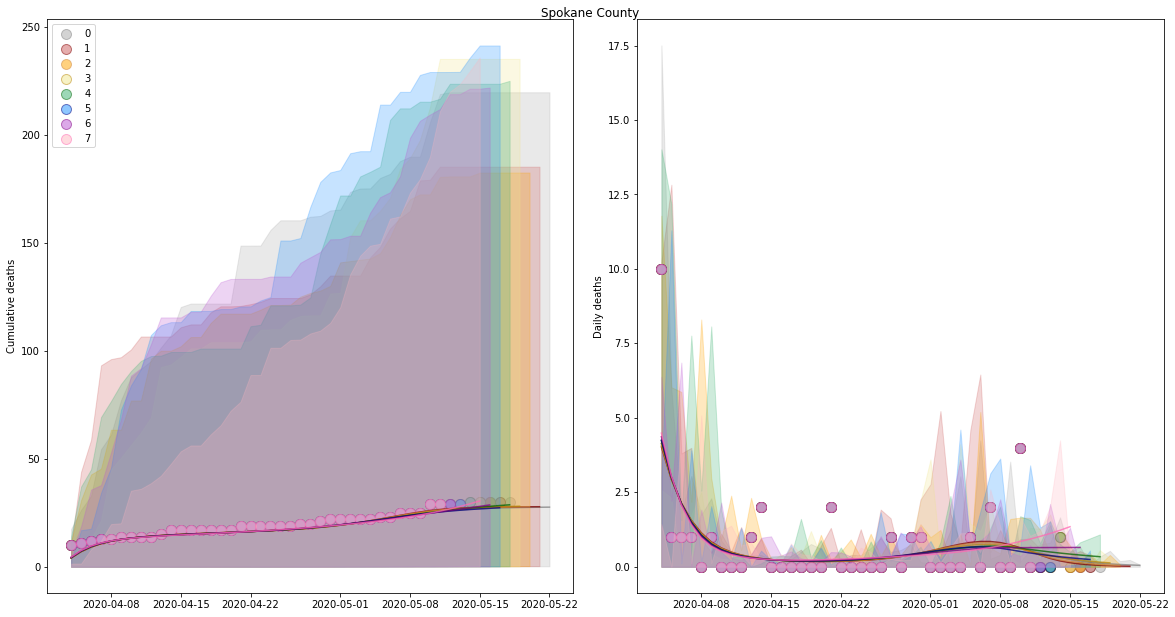

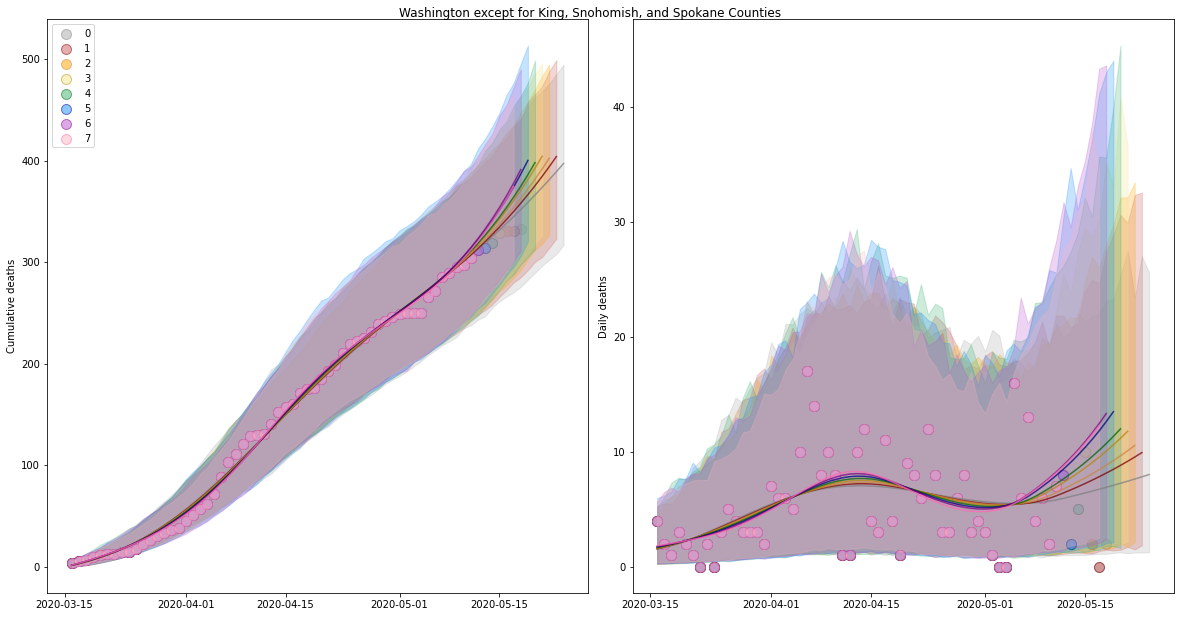

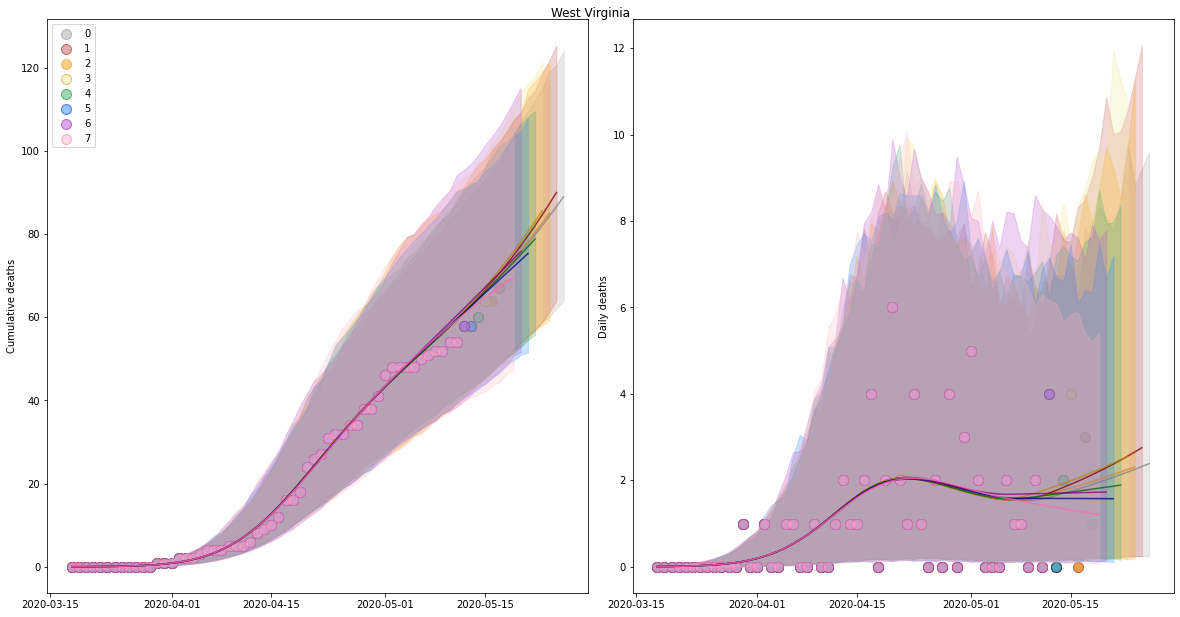

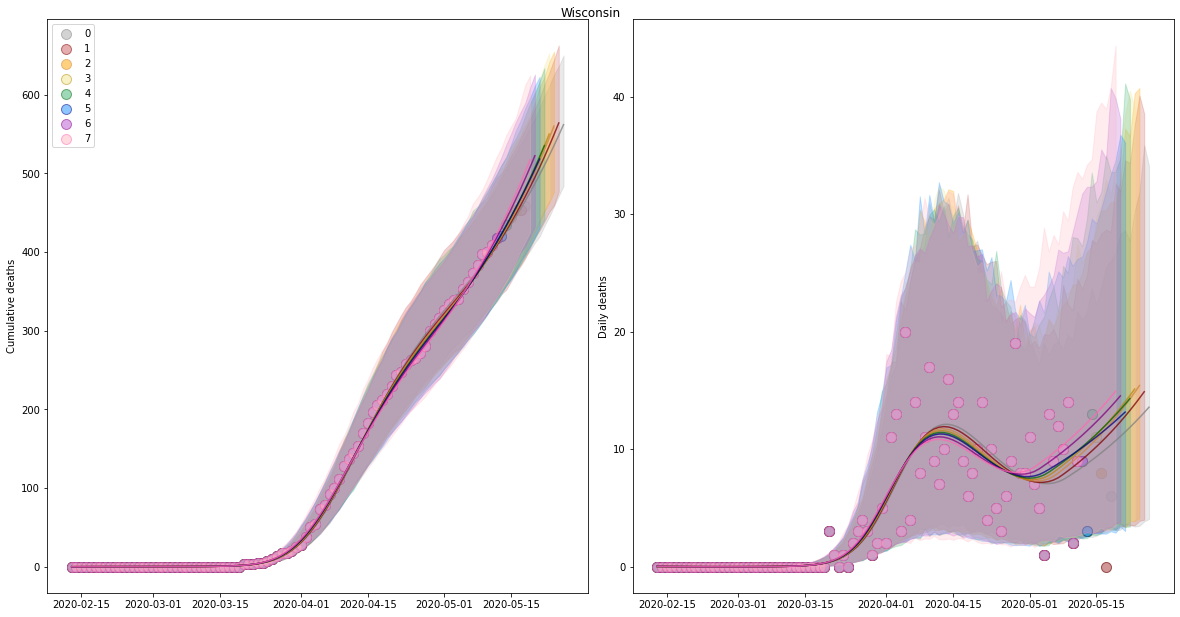

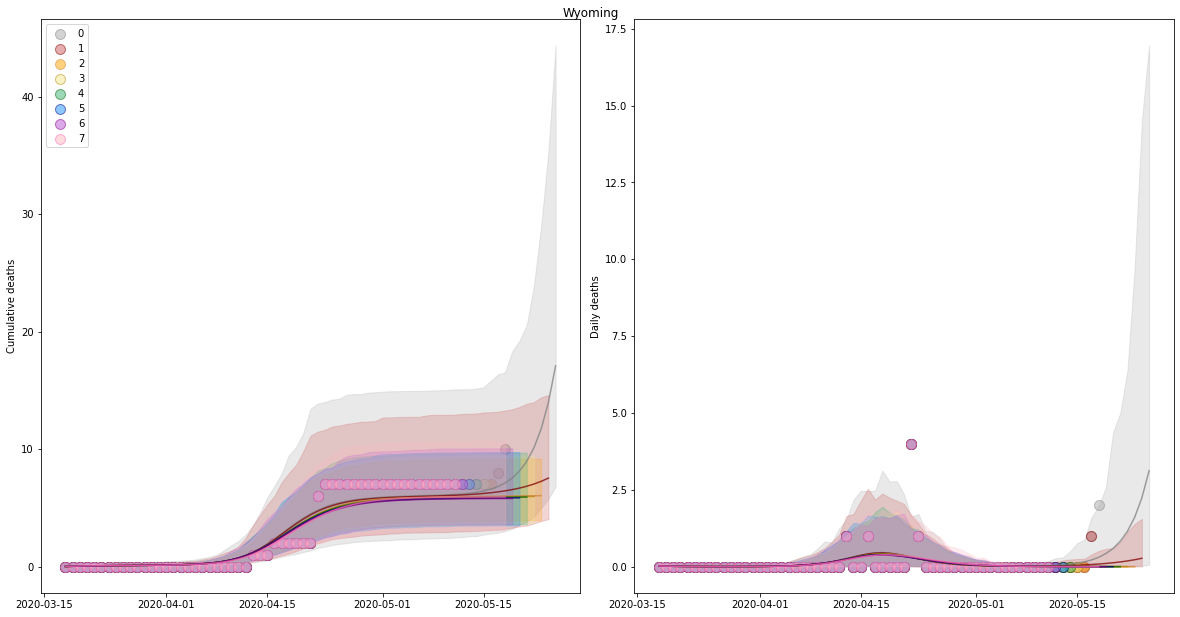

In [8]:
loc_df = get_location_metadata(location_set_id=111, location_set_version_id=677)
location_ids = loc_df.loc[(loc_df['path_to_top_parent'].str.startswith('102,')) & (loc_df['most_detailed'] == 1), 
                          'location_id'].to_list()
location_names = loc_df.loc[(loc_df['path_to_top_parent'].str.startswith('102,')) & (loc_df['most_detailed'] == 1), 
                            'location_name'].to_list()

for location_id, location_name in zip(location_ids, location_names):
    fig, ax = plt.subplots(1, 2, figsize=(16.5, 8.5))
    for df_idx, fillcolor, linecolor in zip(reversed(range(8)),
                                            ['darkgrey', 'indianred', 'orange', 'khaki', 'mediumseagreen', 'dodgerblue', 
                                             'mediumorchid', 'lightpink'],
                                            ['grey', 'maroon', 'peru', 'darkgoldenrod', 'darkgreen', 'navy', 
                                             'purple', 'hotpink']):
        holdouts = 7 - df_idx
        plot_data = data_dfs[holdouts].loc[data_dfs[holdouts]['location_id'] == location_id].reset_index(drop=True)
        plot_est = est_dfs[holdouts].loc[est_dfs[holdouts]['location_id'] == location_id].reset_index(drop=True)
        
        # observed
        ax[0].scatter(plot_data['date'], plot_data['Cumulative observed'],
                      c=fillcolor, edgecolors=linecolor, s=100, alpha=0.5,
                      label=holdouts)
        ax[0].plot(plot_est['date'], plot_est['Cumulative mean'],
                   color=linecolor, alpha=0.75)
        ax[0].fill_between(plot_est['date'], 
                           plot_est['Cumulative lower'], plot_est['Cumulative upper'],
                           color=fillcolor, alpha=0.25)
        ax[0].set_ylabel('Cumulative deaths')
        ax[1].scatter(plot_data['date'], plot_data['Daily observed'],
                      c=fillcolor, edgecolors=linecolor, s=100, alpha=0.5)
        ax[1].plot(plot_est['date'], plot_est['Daily mean'],
                   color=linecolor, alpha=0.75)
        ax[1].fill_between(plot_est['date'], 
                           plot_est['Daily lower'], plot_est['Daily upper'],
                           color=fillcolor, alpha=0.25)
        ax[1].set_ylabel('Daily deaths')

        ax[0].legend(loc=2)
    fig.suptitle(location_name, y=1.0025)
    fig.tight_layout()
